## Data Science 2 lab - Exercise 2
### Solution by Son Levi (207181868) and Gal Hanuna (205857675)

## Install the Dataset Library

In [1]:
#!pip install ucimlrepo

##**Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import torch.nn as nn
#from google.colab import drive
import torch.nn.functional as F
import torchvision


import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score

from ucimlrepo import fetch_ucirepo
from statsmodels.tsa.seasonal import seasonal_decompose

## Load the dataset from the ucimlrepo
*Edit using a fraction of data due to memory consumption, mainly the final portion of information.

In [3]:
# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# Calculating the number of rows corresponding to the last 15%
#n_rows = int(0.15 * len(X))

# Selecting the last 15% of the rows
#X = X.iloc[-n_rows:]

# Output the shape of the selected data to verify
print(X.shape)

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


(2075259, 9)


In [4]:
# Combine features and targets into a single DataFrame
df = X.copy()
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


Overall we can see the data is a storage of electrical consumption measurements in a certain time period (every observation is based on 1 minute step for 4 years):
1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt).**The target value of this data**
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [5]:
print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())


Data Types:
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Missing Values:
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


We have null values in the Sub_metering_3 parameter and not all the values are in their correct data type, so we'll clean the data before adding to the model.

##  Data Cleaning
  - We'll remove the observations that have null values and mapp the data types based on the needed data types for the dataframe.

In [6]:
# Handle missing values if any (example: fill with mean/mode, drop rows, etc.)
df = df.dropna()  # Dropping rows with missing values for simplicity

# Convert data types if necessary
data_type_mapping = {
    'Date': 'datetime64',
    'Global_reactive_power': 'float',
    'Global_active_power': 'float',
    'Global_intensity': 'float',
    'Voltage': 'float',
    'Sub_metering_1': 'float',
    'Sub_metering_2': 'float'
}

for column, dtype in data_type_mapping.items():
    if column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce') if 'float' in dtype else pd.to_datetime(df[column]) if 'datetime' in dtype else pd.to_datetime(df[column], format='%H:%M').dt.time

C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\1822127900.py:17: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[column] = pd.to_numeric(df[column], errors='coerce') if 'float' in dtype else pd.to_datetime(df[column]) if 'datetime' in dtype else pd.to_datetime(df[column], format='%H:%M').dt.time
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\1822127900.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce') if 'float' in dtype else pd.to_datetime(df[column]) if 'datetime' in dtype else pd.to_datetime(df[column], format='%H:%M').dt.time


In [7]:
print(df.dtypes)
df

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


## Visualize Time Series Trends

C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\2046734744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))


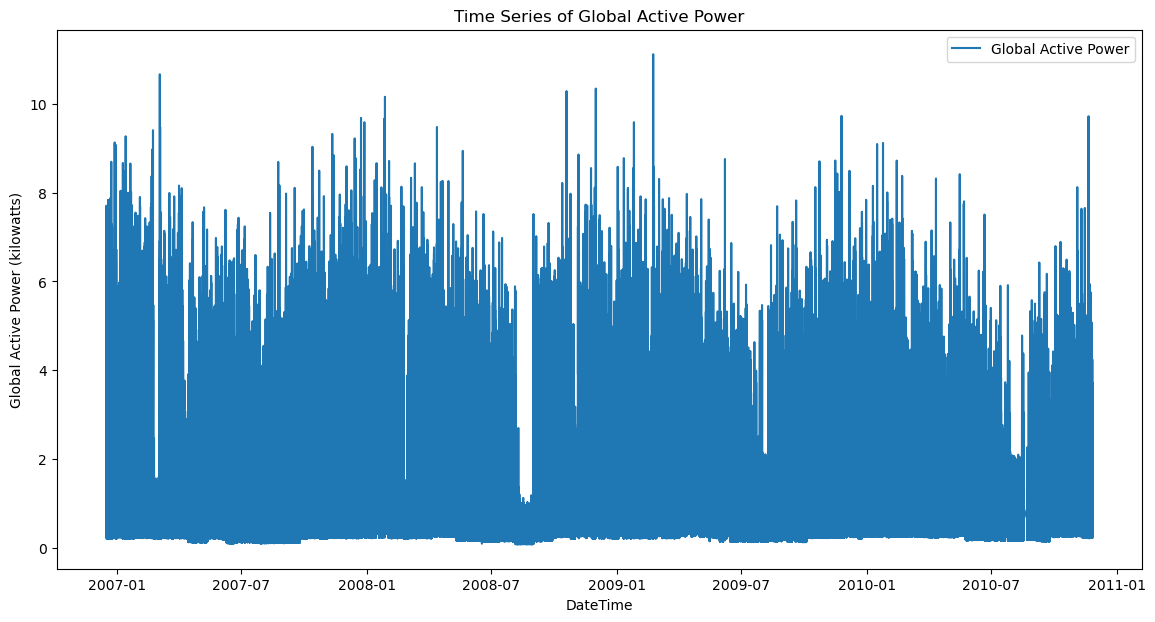

In [8]:
# Combine Date and Time into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

# Plot time series for Global Active Power
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power')
plt.title('Time Series of Global Active Power')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\111912592.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data = daily_data.fillna(method='ffill')
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\111912592.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data = daily_data.fillna(method='bfill')


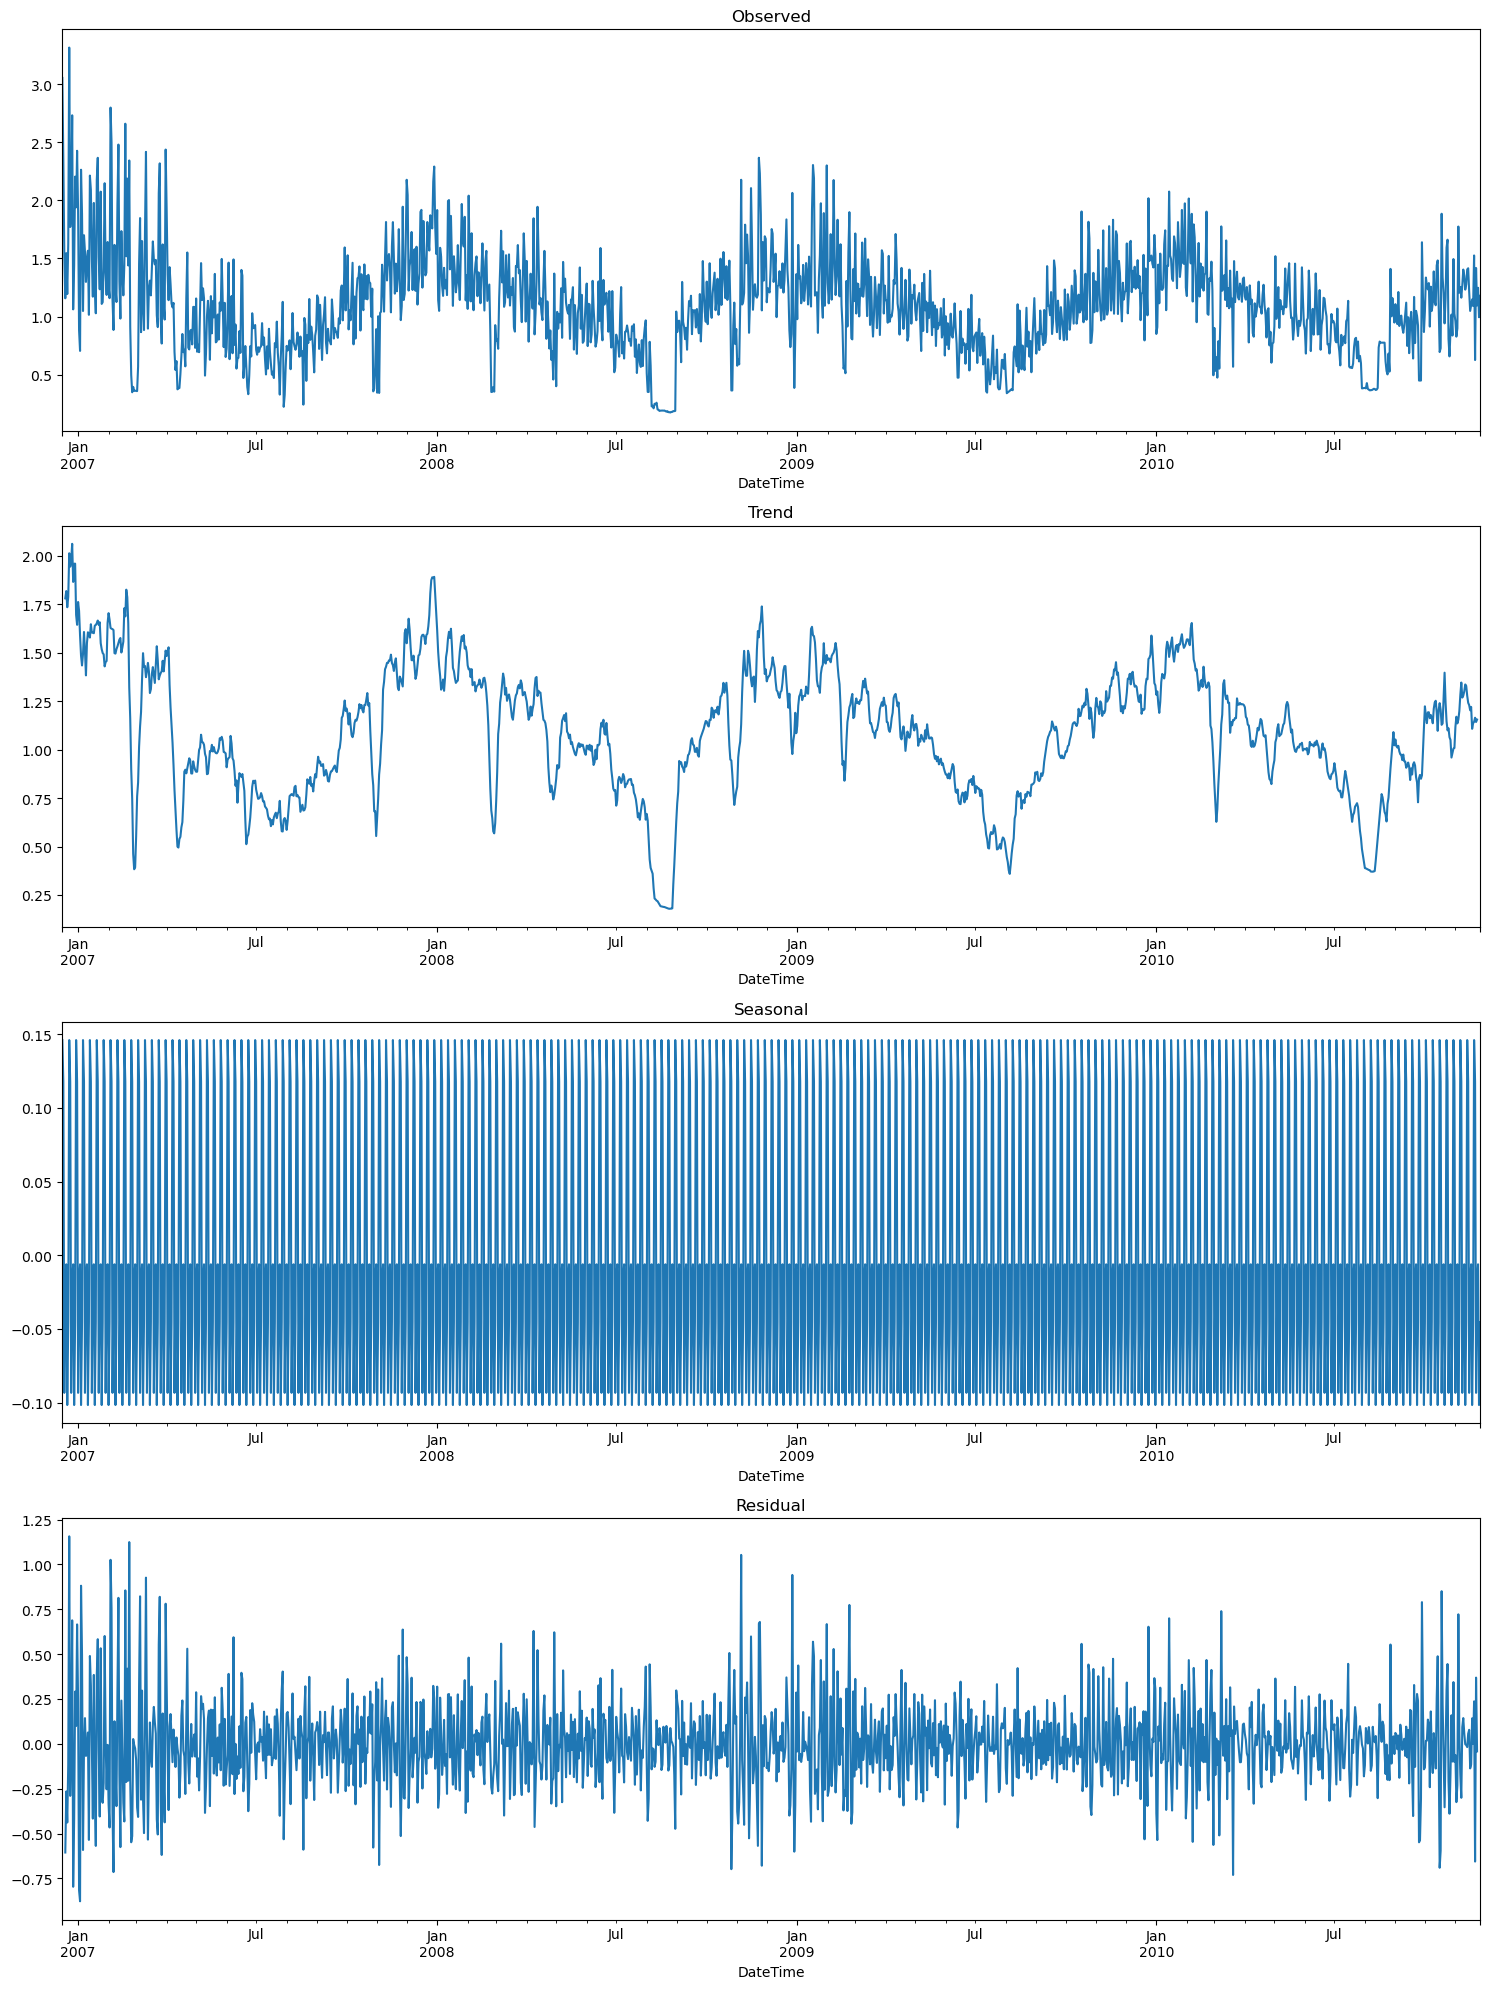

In [9]:
# Check for seasonality and cyclical patterns
# Resample to daily data for clearer visualization
daily_data = df['Global_active_power'].resample('D').mean()

# Handle missing values by forward filling
daily_data = daily_data.fillna(method='ffill')

# If there are still any missing values at the beginning, backward fill
daily_data = daily_data.fillna(method='bfill')

# Perform seasonal decomposition
result = seasonal_decompose(daily_data, model='additive', period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

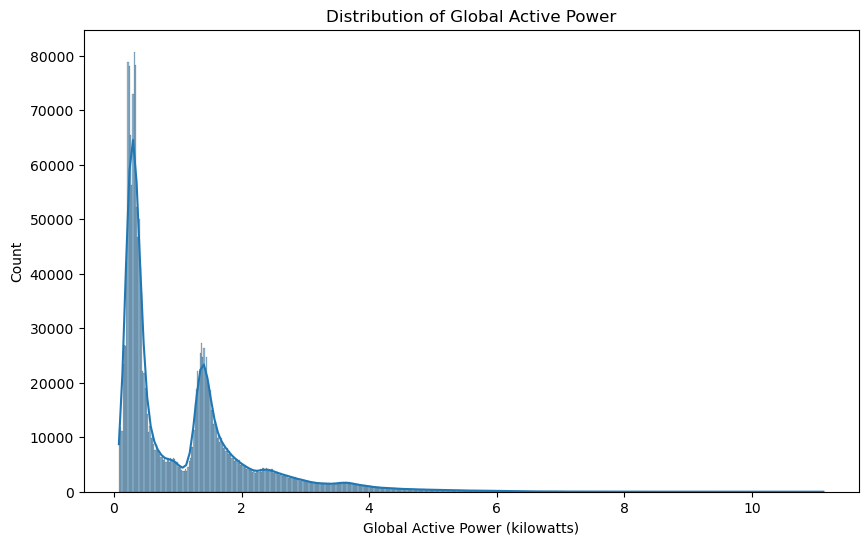

In [10]:
# Analyze distribution of power consumption
plt.figure(figsize=(10, 6))
sns.histplot(df['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.show()


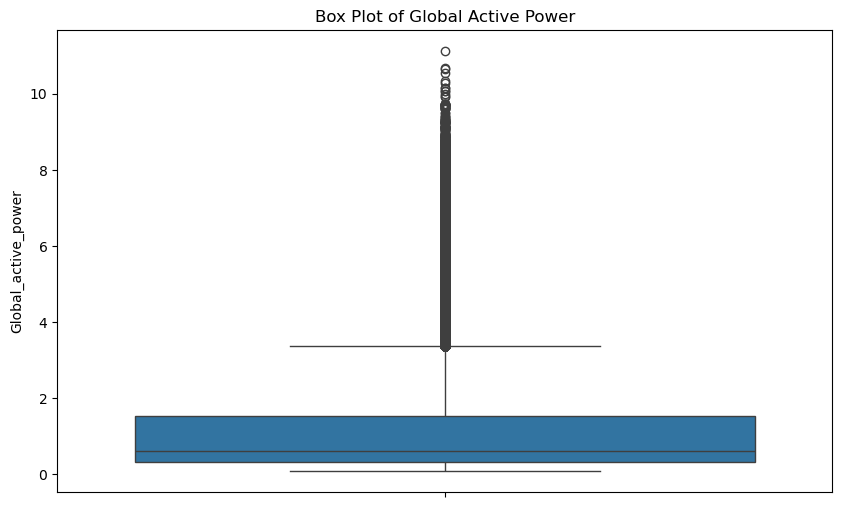

C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\408467071.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Global_active_power_capped'] = df['Global_active_power'].clip(upper=upper_limit)


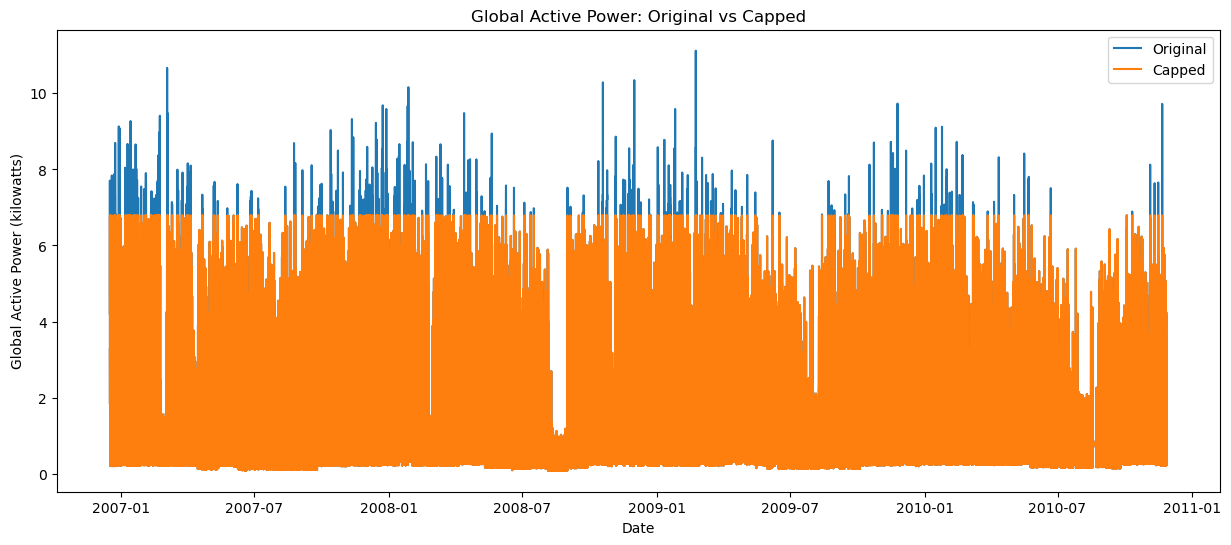

In [11]:
# Check for outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Global_active_power'])
plt.title('Box Plot of Global Active Power')
plt.show()

# Handle outliers (example: capping at 99th percentile)
upper_limit = df['Global_active_power'].quantile(0.999)
df['Global_active_power_capped'] = df['Global_active_power'].clip(upper=upper_limit)

# Visualize the effect of outlier handling
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Global_active_power'], label='Original')
plt.plot(df.index, df['Global_active_power_capped'], label='Capped')
plt.title('Global Active Power: Original vs Capped')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

##Feature Extraction

In [12]:
# Step 3: Create time-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour

time_labels_distribution = {'Hour': 60, 'Day': 24*60,
                            'Month': 30*24*60, 'Year': 30*24*60*12}

# Create lag variables
for time_label, multiplier in time_labels_distribution.items():
    for lag in range(1, 4):
        df[f'{time_label}_lag_{lag}'] = df['Global_active_power_capped'].shift(lag * multiplier)


C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\1585759184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df.index.year
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\1585759184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df.index.month
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\1585759184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [13]:
# fill with NaN values due to lag creation
df.fillna(0, inplace=True)
df=df.drop(columns=['Date','Time'])

# Check the prepared feature
df.tail()

C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\26073214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_capped,Year,Month,...,Hour_lag_3,Day_lag_1,Day_lag_2,Day_lag_3,Month_lag_1,Month_lag_2,Month_lag_3,Year_lag_1,Year_lag_2,Year_lag_3
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,0.946,2010,11,...,1.052,1.522,1.956,2.520,0.510,1.292,0.198,0.420,1.746,2.334
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0,0.944,2010,11,...,1.062,1.518,1.954,2.448,0.510,1.286,0.226,0.406,1.722,3.282
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,0.938,2010,11,...,1.096,1.512,1.950,2.430,0.506,1.286,0.302,0.408,0.312,3.496
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0,0.934,2010,11,...,1.094,1.508,1.958,2.432,0.502,1.284,0.298,0.408,0.402,3.570
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0,0.932,2010,11,...,1.086,1.502,2.016,2.376,0.498,1.284,0.288,0.418,0.400,3.564


## Correlation matrix

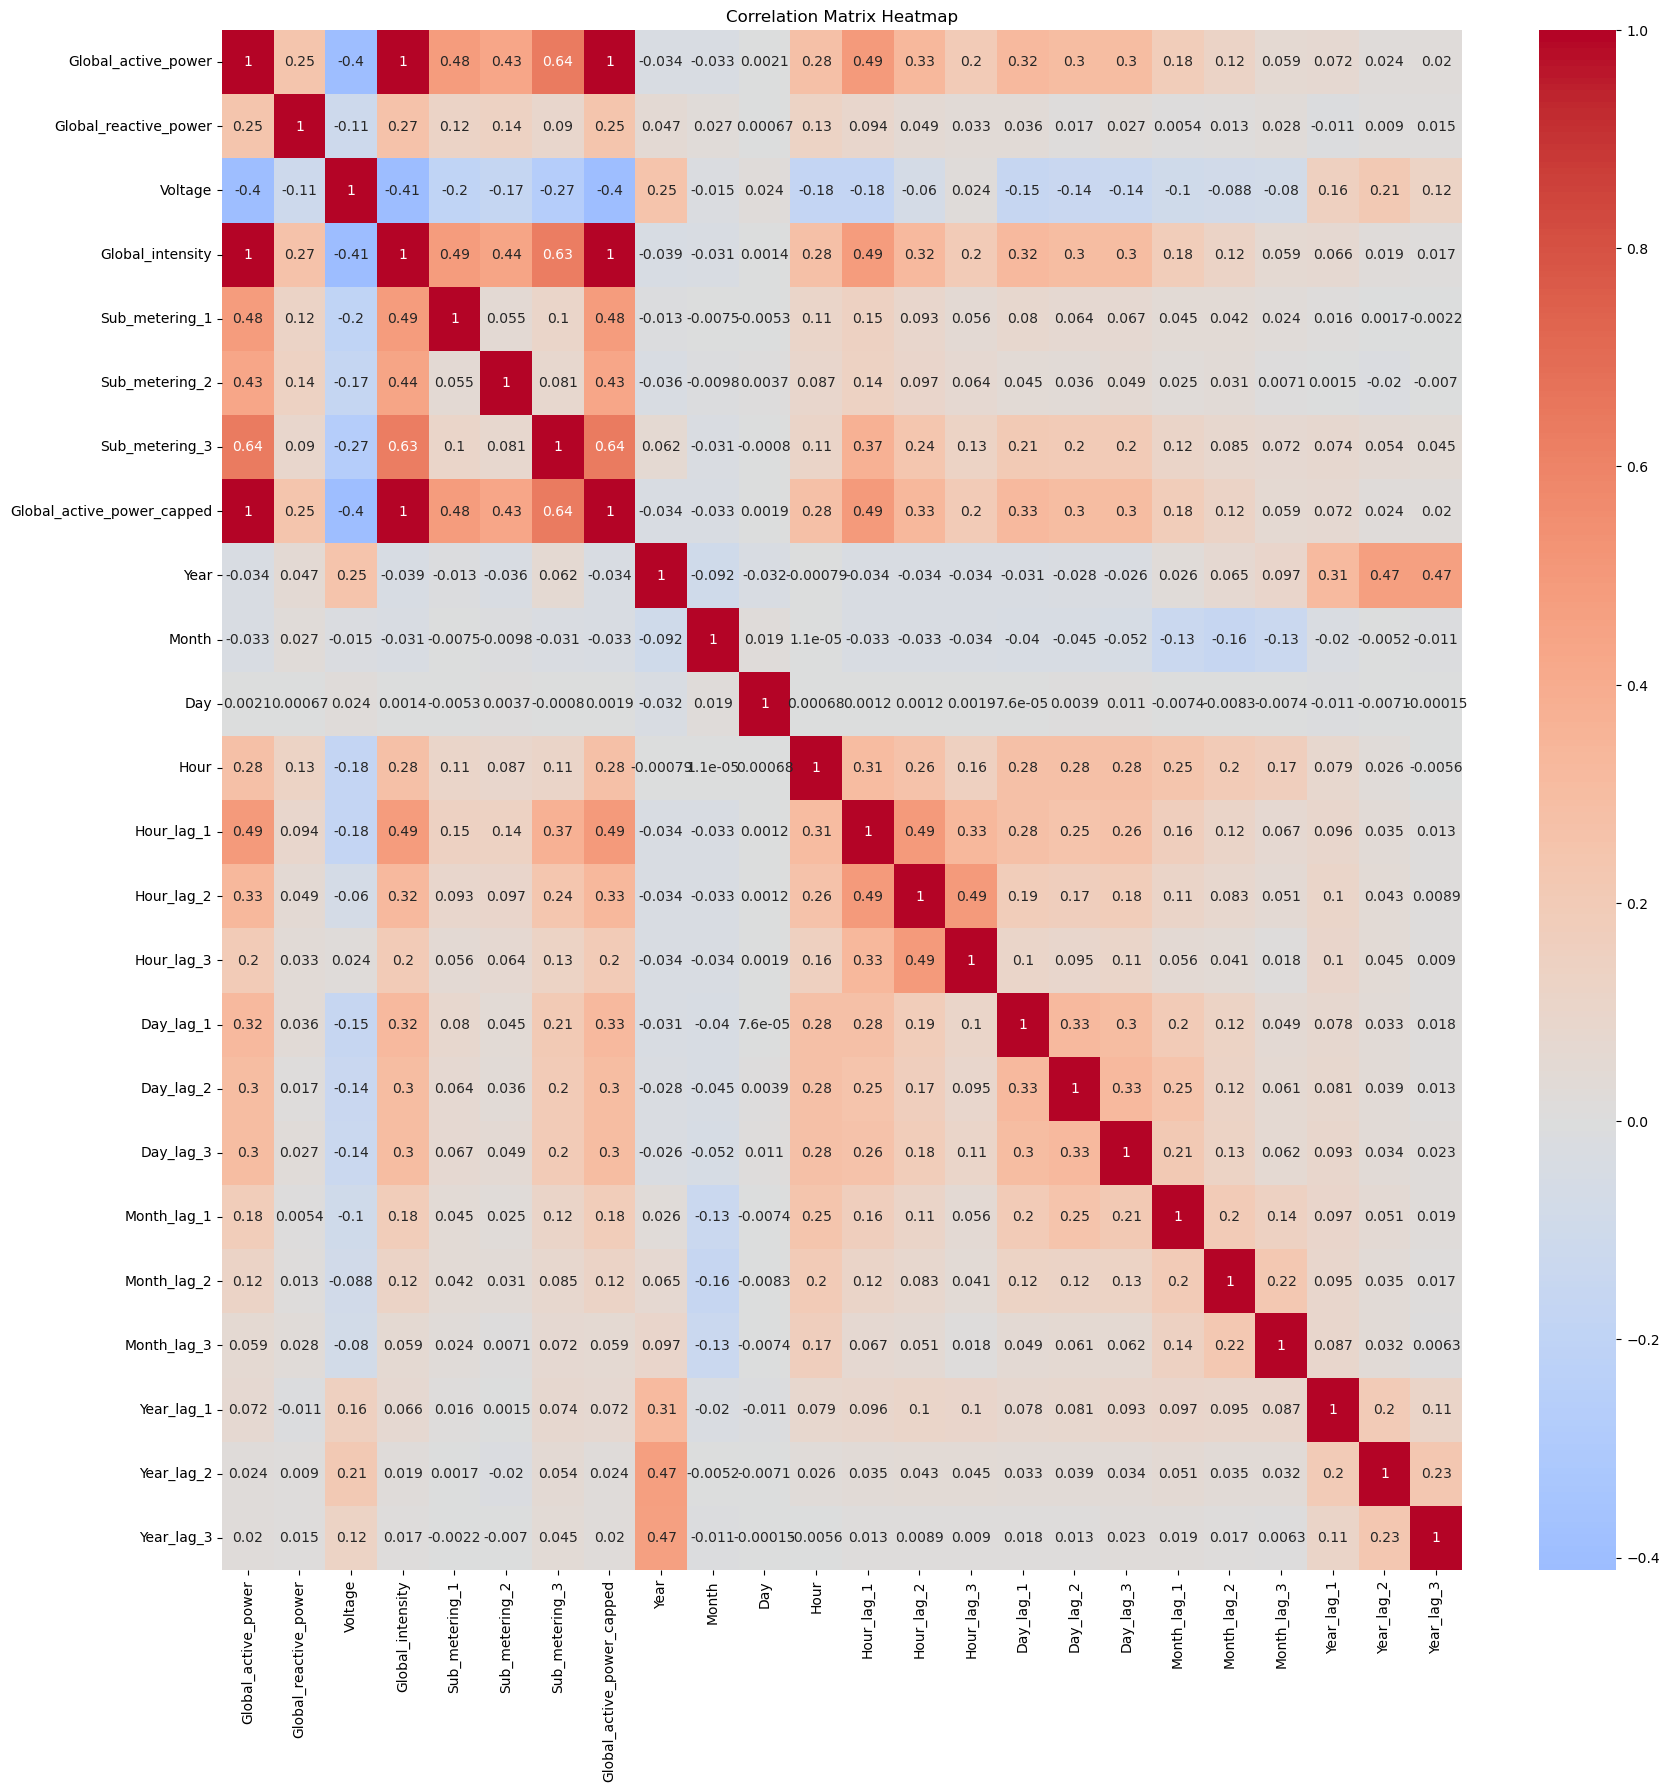

In [14]:
# Compute the correlation matrix
corr = df.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Correlation Heatmap Conclusions:
1. Since Global active power is our target feature we'll drop it from the data and move it to a seperate variable.
2. Global active power and Global intensity are 100% correlated! This is explained with the fact that their linear between eachother:

#### **Ohm's Law**
**\[ P = VI \]**

where:

- \( P \) is the power through the conductor in watt (W), which in this case is power consumption.
- \( I \) is the current through the conductor in amperes (A), which in this case is power intenstity.
- \( V \) is the voltage (potential difference) across the conductor in volts (V), which in this case is mostly between 239/240 volt.

In [15]:
X = df.drop(columns=['Global_active_power', 'Global_active_power_capped','Global_intensity'])  # Features
y = df['Global_active_power_capped']   # Target
y = y.values.reshape(-1,1)

print(y.shape)

(2049280, 1)


##New Correlation matrix

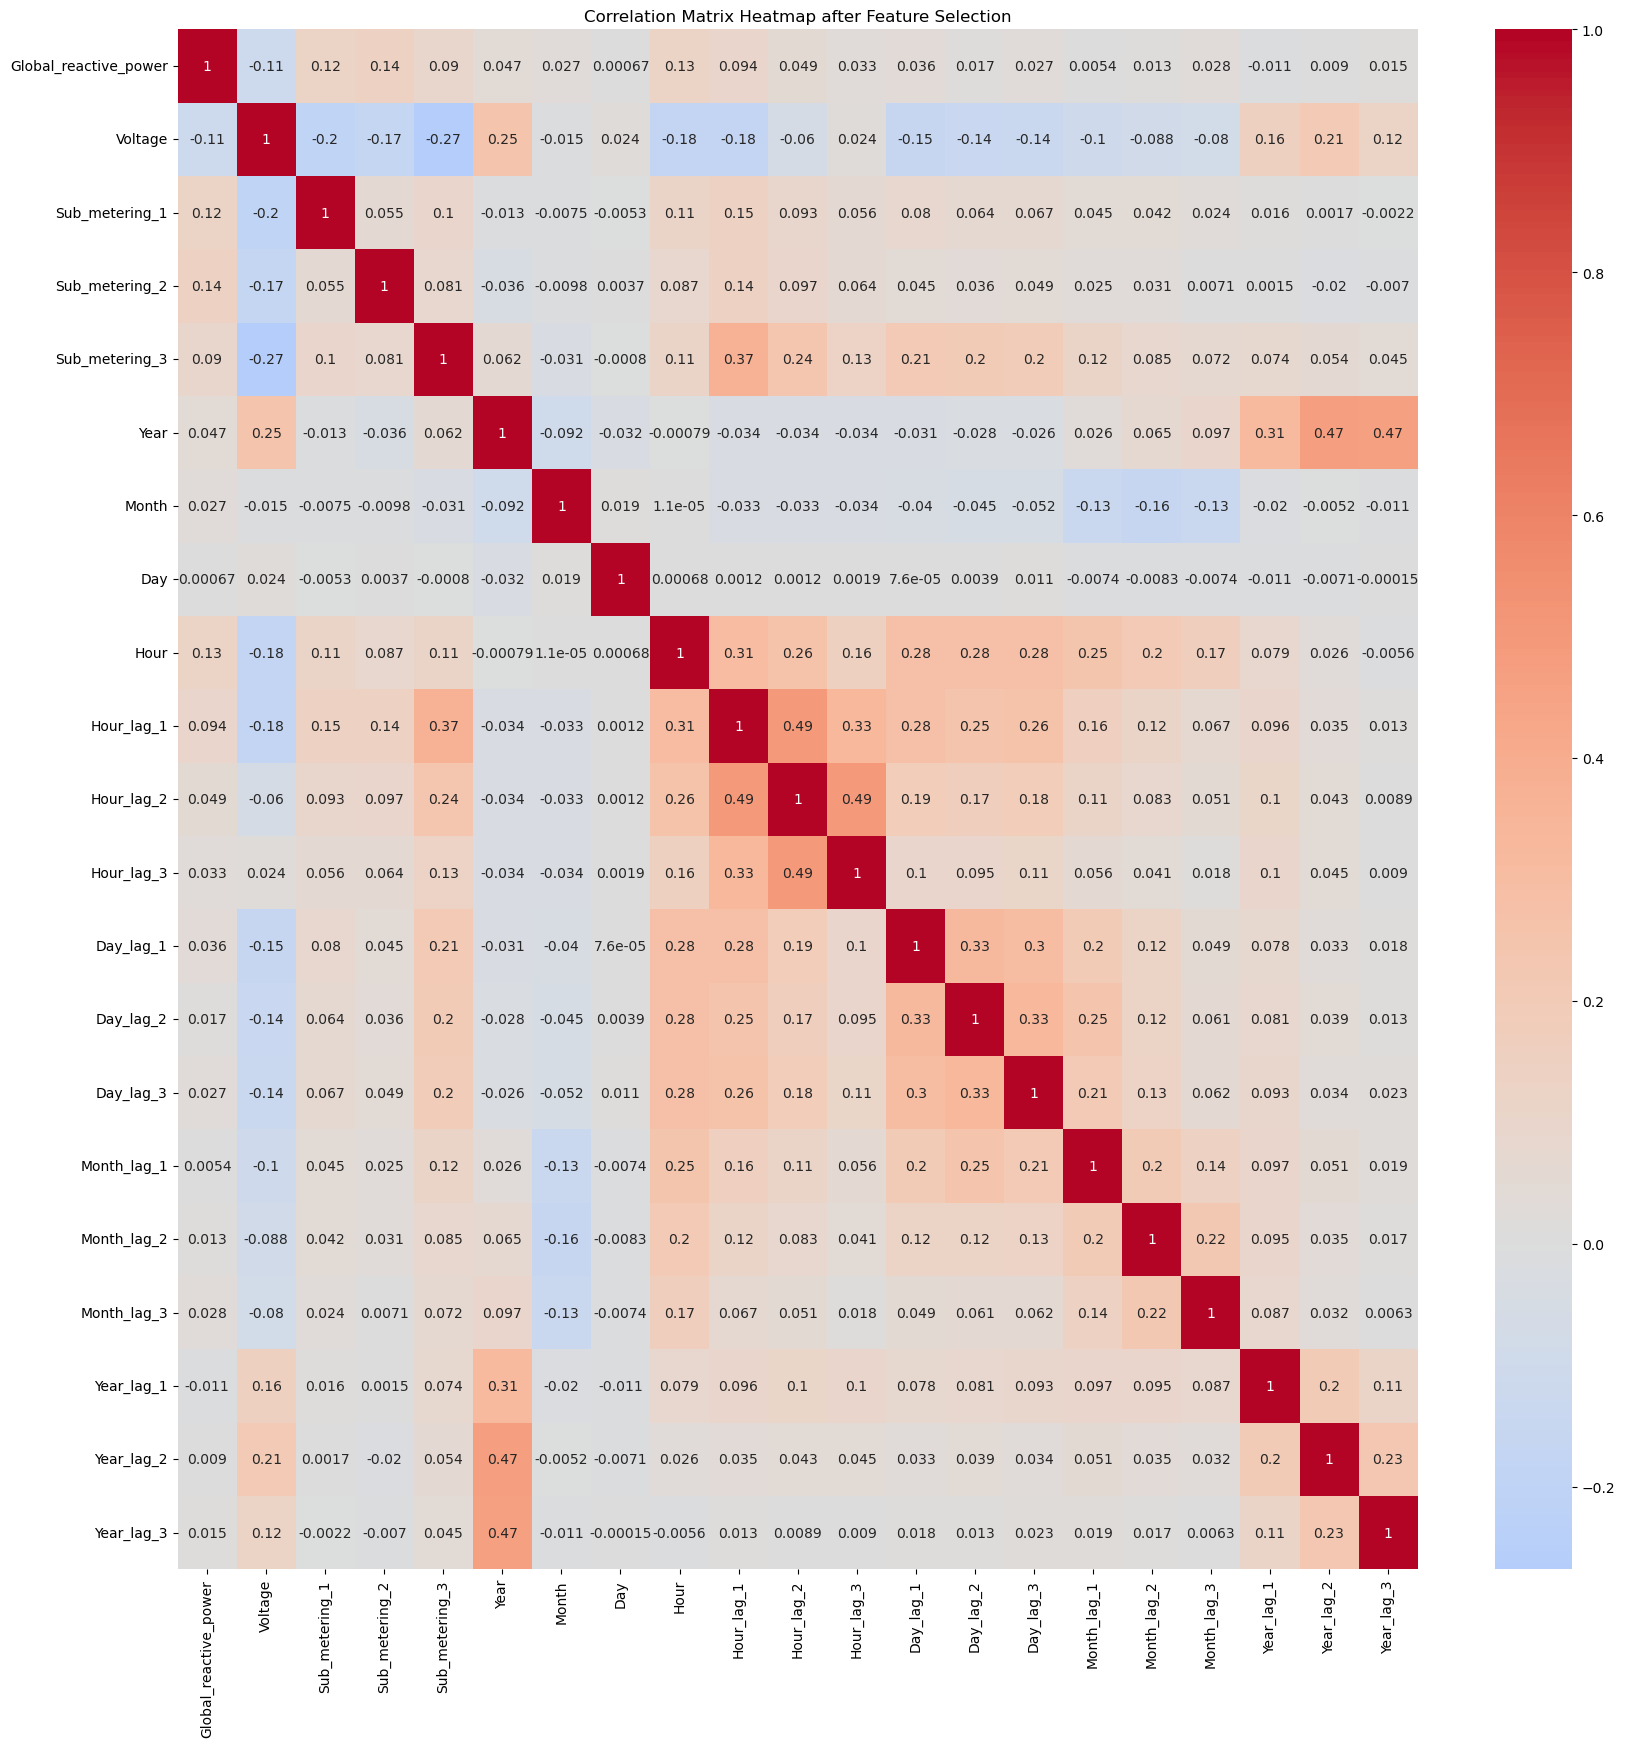

In [16]:
# Compute the correlation matrix
corr = X.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap after Feature Selection')
plt.show()

## **Linear Regression**
#### Split the data into train and validation (65% train and 35% validation) indicating close to 3 months of testing data. and train the model.

In [17]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=False)

In [18]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model using the training set
model.fit(X_train, y_train)

# Predict the scores on the validation set
y_pred = model.predict(X_valid)

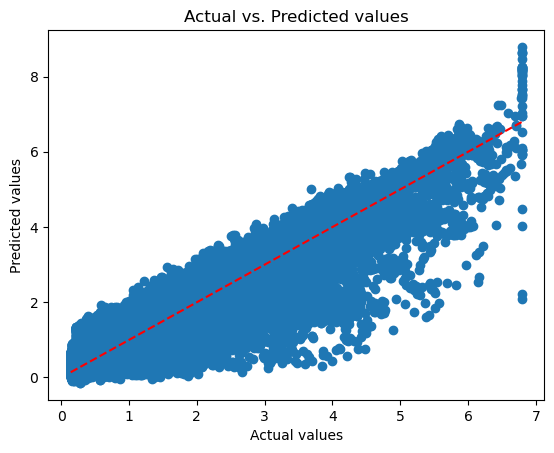

In [19]:
# Scatter plot of actual vs. predicted values
plt.scatter(y_valid, y_pred)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], 'r--')  # Line for perfect prediction
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values')
plt.show()

### Evaluation

In [20]:
# Evaluate the model's performance on the validation set
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

Mean Absolute Error on Validation Set: 0.2525584566183506
Mean Squared Error on Validation Set: 0.12541253997356977
Root Mean Squared Error on Validation Set: 0.3541363296437825
R^2 Score on Validation Set: 0.830711465679751


The predicted values in Linear Regression are quite close to the actual values, only slightly lower, but R^2 is high enough to be considered linear data.

## **Model and Preprocessing Functions**

### Preprocessing
    - label = {"LR","RNN","LSTM","LSTM Attention"}

In [177]:
def preprocessData(data, target, label="LR", seq_length=30, time_step=1):
  if isinstance(data, (list, np.ndarray)):
    data_array = np.array(data)
    target_array = np.array(target)
  else:  # Assume it's a pandas DataFrame or Series
    data_array = data.values
    target_array = target.values

  if label == "RNN":
    X, y = create_sequences(data_array, target_array, seq_length)
  elif label == "LSTM" or "LSTM Attention":
    X, y = create_time_steps(data_array, target_array, time_step)
  else:
    print("No model Selected! Assumed Linear Regression")
  return X, y


### Models

In [59]:
def rnn_model(X_train, X_valid, y_train, y_valid, sequence_length, epochs=20,batch_size=32):
  # Define the RNN model
  model_rnn = Sequential()
  model_rnn.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
  model_rnn.add(Dense(1))
  model_rnn.compile(optimizer='adam', loss='mse')

  # Define early stopping and reduce learning rate on plateau
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Train the RNN model
  history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping])
  return model_rnn, history

def lstm_model(X_train, X_valid, y_train, y_valid, time_step, epochs=30, batch_size=64):
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_step, X_train.shape[2])))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Define early stopping and reduce learning rate on plateau
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid),
                        verbose=2, shuffle=False, callbacks=[early_stopping])

    # Evaluate the model
    loss = model.evaluate(X_valid, y_valid, verbose=0)
    print(f'Validation Loss: {loss}')

    return model, history, loss

## **RNN**

In [23]:
# Function to create sequences for RNN
def create_sequences(data,target, seq_length):
  if isinstance(data, (list, np.ndarray)):
    data_array = np.array(data)
    target_array = np.array(target)
  else:  # Assume it's a pandas DataFrame or Series
    data_array = data.values
    target_array = target.values

  num_sequences = len(data_array) - seq_length

  xs = np.array([data_array[i:i+seq_length] for i in range(num_sequences)])
  ys = target_array[seq_length:]

  return np.array(xs),np.array(ys)

In [24]:
# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
y_scaled = scaler.fit_transform(y)

# Convert back to DataFrame to keep consistency with the rest of your code
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
y_scaled = pd.DataFrame(y_scaled)

# Define sequence length
SEQ_LENGTH = 30
TIME_STEPS = 1

# Create sequences for training and testing
X_RNN, y_RNN = preprocessData(df_scaled,y_scaled,"RNN", seq_length=SEQ_LENGTH)
print(X.shape)
print(y.shape)

(2049280, 21)
(2049280, 1)


In [25]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_RNN, y_RNN, test_size=0.35, shuffle=False)

model, history = rnn_model(X_train, X_valid, y_train, y_valid, SEQ_LENGTH, epochs=10, batch_size=64)

# Evaluate the RNN model
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 2/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 139s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 143s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - loss: 0.0013 - val_loss: 0.0012
22414/22414 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
Mean Absolute Error on Validation Set: 0.0146779813030858
Mean Squared Error on Validation Set: 0.001077399000145912
Root Mean Squared Error on Validation Set: 0.03282375664280236
R^2 Score on Validation Set: 0.9464900807952318


Compared to Linear Regression, the postprocessing metrics show improved results using RNN, where on the newly tested data, all the errors have reduced and R^2 score has increased and is closer to 1.

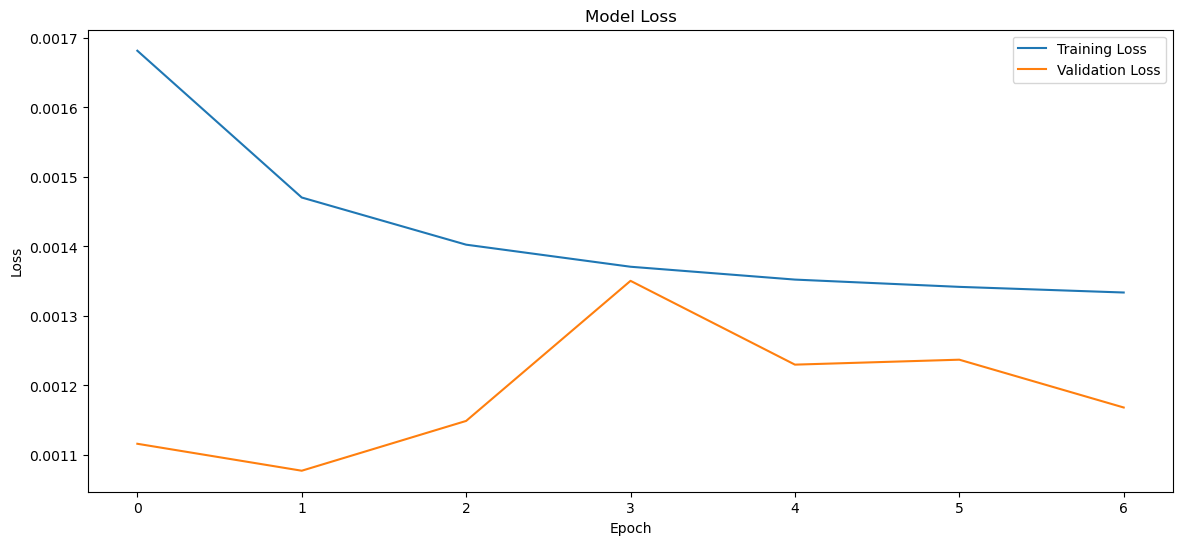

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

###### **Observations:**

**Training and Validation Loss:**
- The training loss starts low and decreases gradually over epochs, which is typical for a well-behaved model.
- The validation loss starts lower than the training loss and shows a decreasing trend initially, but fluctuates slightly across epochs.
- The low initial loss could be due to good initialization of the model parameters, appropriate preprocessing of the data, or the simplicity of the task.

**Metrics:**

- The R² score of 0.9469 indicates that the model explains approximately 94.96% of the variance in the validation data, which is quite good.
- Low MAE and RMSE values suggest that the model's predictions are close to the actual values.

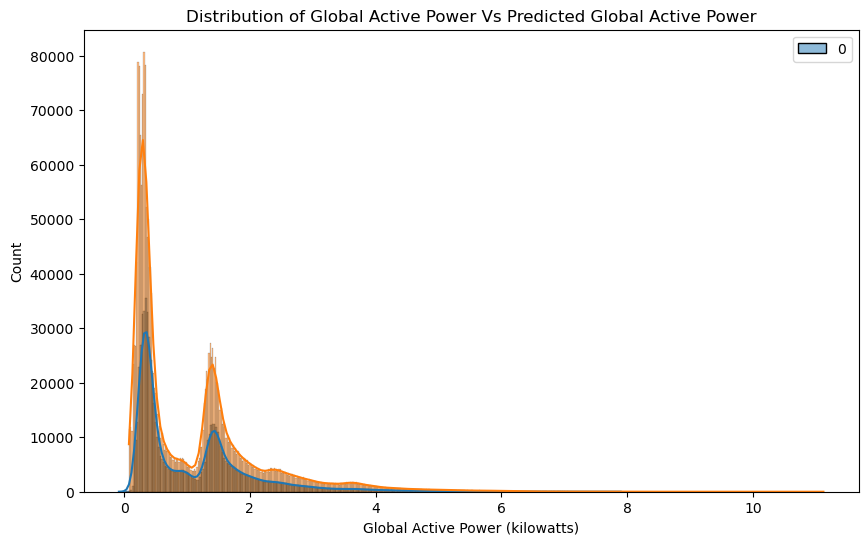

In [27]:
y_pred = scaler.inverse_transform(y_pred)

# Analyze distribution of power consumption
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True)
sns.histplot(df['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power Vs Predicted Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.show()

The Distribution of the Predicted Active power is close to the original, meaning our RNN model is fairly accurate.

## **LSTM**

time steps = 1

In [30]:
from keras.layers import LSTM, Dense

X = df.drop(columns=['Global_active_power', 'Global_active_power_capped','Global_intensity'])  # Features
y = df['Global_active_power_capped']   # Target

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=False)

# X_train, X_valid, y_train, y_valid are already defined
# Convert the DataFrames to NumPy arrays
X_train_array = X_train.values
X_valid_array = X_valid.values

# Reshape the data to be 3D [samples, time steps, features]
# Here, we assume the time steps to be 1 and features to be the number of features in X_train
X_train_array = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_valid_array = X_valid_array.reshape((X_valid_array.shape[0], 1, X_valid_array.shape[1]))

In [31]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_array.shape[1], X_train_array.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_array, y_train, epochs=30, batch_size=64, validation_data=(X_valid_array, y_valid), verbose=2, shuffle=False)

# Evaluate the model
loss = model.evaluate(X_valid_array, y_valid, verbose=0)
print(f'Validation Loss: {loss}')

# Make predictions
y_pred = model.predict(X_valid_array)

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
27217/27217 - 41s - 2ms/step - loss: 25.6810 - val_loss: 1.1518
Epoch 2/30
27217/27217 - 39s - 1ms/step - loss: 0.4743 - val_loss: 0.1382
Epoch 3/30
27217/27217 - 39s - 1ms/step - loss: 0.2954 - val_loss: 0.1374
Epoch 4/30
27217/27217 - 39s - 1ms/step - loss: 0.2876 - val_loss: 0.1359
Epoch 5/30
27217/27217 - 40s - 1ms/step - loss: 0.2845 - val_loss: 0.1341
Epoch 6/30
27217/27217 - 40s - 1ms/step - loss: 0.2822 - val_loss: 0.1320
Epoch 7/30
27217/27217 - 40s - 1ms/step - loss: 0.2802 - val_loss: 0.1302
Epoch 8/30
27217/27217 - 40s - 1ms/step - loss: 0.2784 - val_loss: 0.1284
Epoch 9/30
27217/27217 - 40s - 1ms/step - loss: 0.2768 - val_loss: 0.1270
Epoch 10/30
27217/27217 - 40s - 1ms/step - loss: 0.2753 - val_loss: 0.1258
Epoch 11/30
27217/27217 - 41s - 1ms/step - loss: 0.2739 - val_loss: 0.1247
Epoch 12/30
27217/27217 - 40s - 1ms/step - loss: 0.2726 - val_loss: 0.1239
Epoch 13/30
27217/27217 - 40s - 1ms/step - loss: 0.2714 - val_loss: 0.1233
Epoch 14/30
27217/27217 - 39s - 1

In [32]:
# Evaluate the model
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

Mean Absolute Error on Validation Set: 0.2559412763265336
Mean Squared Error on Validation Set: 0.12659808420357813
Root Mean Squared Error on Validation Set: 0.35580624531277993
R^2 Score on Validation Set: 0.8291111548566686


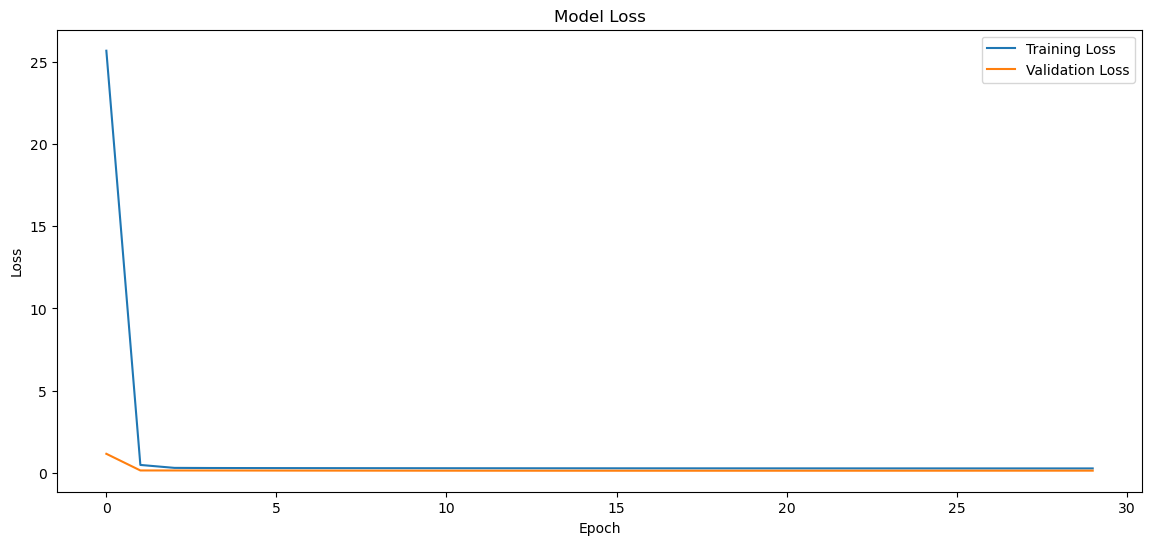

In [33]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

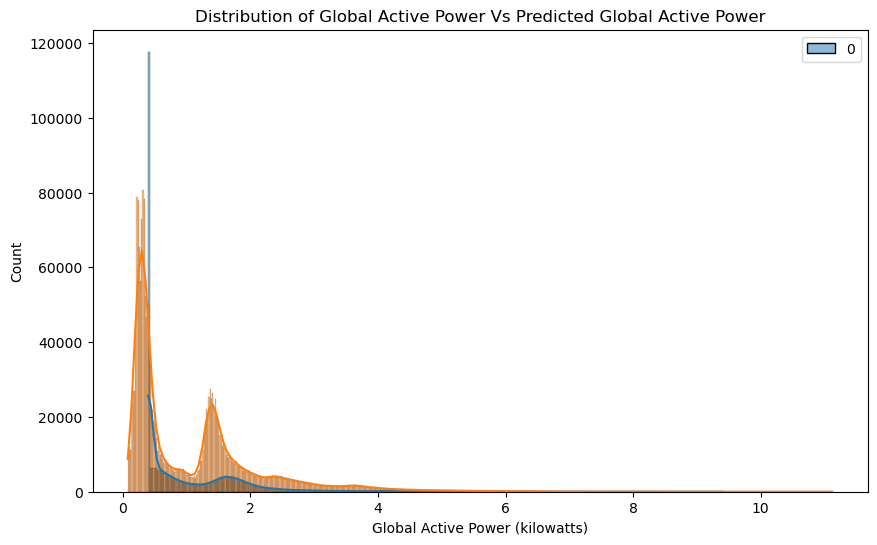

In [34]:
# Analyze distribution of power consumption
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True)
sns.histplot(df['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power Vs Predicted Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.show()

**Observations:**

**Loss  Graph**The plot shows that the training and validation loss rapidly decrease and stabilize after the initial epochs, indicating that the model has learned effectively during training. Both losses are very close to each other, which suggests that the model is not overfitting or underfitting.

**Metrics:**

The R² score of 0.82911 indicates that approximately 82.91% of the variance in the validation set is explained by the LSTM model. This is lower than our RNN model's performance (R² of 0.9469), yet pretty good.
The LSTM model demonstrates good performance with low MAE, MSE, and RMSE values, and a high R^2 score. This suggests that the model is accurate in predicting global active power.
The similarity in the distribution of actual and predicted values indicates that the model effectively captures the underlying patterns in the data.

**Distribution Graph:**

The predicted values closely follow the actual values, with some deviations at certain points. The peaks and overall shape of the distributions are similar, indicating that the LSTM model performs well in capturing the distribution of the target variabley.ing.

## **LSTM with Attention**

In [35]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Activation, Lambda, dot, concatenate
from keras.optimizers import Adam
from keras import backend as K

# X_train, X_valid, y_train, y_valid are already defined

In [36]:
from keras.layers import LSTM, Dense

X = df.drop(columns=['Global_active_power', 'Global_active_power_capped','Global_intensity'])  # Features
y = df['Global_active_power_capped']   # Target

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=False)

# X_train, X_valid, y_train, y_valid are already defined
# Convert the DataFrames to NumPy arrays
X_train_array = X_train.values
X_valid_array = X_valid.values

# Reshape the data to be 3D [samples, time steps, features]
# Here, we assume the time steps to be 1 and features to be the number of features in X_train
X_train_array = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_valid_array = X_valid_array.reshape((X_valid_array.shape[0], 1, X_valid_array.shape[1]))

In [37]:
# Define the attention mechanism
def attention_layer(inputs):
    hidden_states = inputs
    hidden_size = int(hidden_states.shape[2])
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weights')(score)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    return context_vector

In [38]:
# Define the model
inputs = Input(shape=(X_train_array.shape[1], X_train_array.shape[2]))
lstm_out = LSTM(50, return_sequences=True, activation='relu')(inputs)
attention_out = attention_layer(lstm_out)
dense_out = Dense(1)(attention_out)
model = Model(inputs=[inputs], outputs=[dense_out])

In [39]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_array, y_train, epochs=22, batch_size=64, validation_data=(X_valid_array, y_valid), verbose=2, shuffle=False)

# Evaluate the model
loss = model.evaluate(X_valid_array, y_valid, verbose=0)
print(f'Validation Loss: {loss}')

# Make predictions
y_pred = model.predict(X_valid_array)

Epoch 1/40


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


27217/27217 - 61s - 2ms/step - loss: 0.8390 - val_loss: 0.2739
Epoch 2/40
27217/27217 - 58s - 2ms/step - loss: 0.3632 - val_loss: 0.1471
Epoch 3/40
27217/27217 - 57s - 2ms/step - loss: 0.2895 - val_loss: 0.1432
Epoch 4/40
27217/27217 - 57s - 2ms/step - loss: 0.2843 - val_loss: 0.1404
Epoch 5/40
27217/27217 - 57s - 2ms/step - loss: 0.2818 - val_loss: 0.1377
Epoch 6/40
27217/27217 - 57s - 2ms/step - loss: 0.2797 - val_loss: 0.1350
Epoch 7/40
27217/27217 - 57s - 2ms/step - loss: 0.2779 - val_loss: 0.1327
Epoch 8/40
27217/27217 - 58s - 2ms/step - loss: 0.2762 - val_loss: 0.1306
Epoch 9/40
27217/27217 - 82s - 3ms/step - loss: 0.2747 - val_loss: 0.1289
Epoch 10/40
27217/27217 - 58s - 2ms/step - loss: 0.2733 - val_loss: 0.1274
Epoch 11/40
27217/27217 - 58s - 2ms/step - loss: 0.2720 - val_loss: 0.1261
Epoch 12/40
27217/27217 - 57s - 2ms/step - loss: 0.2708 - val_loss: 0.1250
Epoch 13/40
27217/27217 - 57s - 2ms/step - loss: 0.2698 - val_loss: 0.1242
Epoch 14/40
27217/27217 - 57s - 2ms/step - lo

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Loss: 0.13033610582351685
  73/9606 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step   

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9606/9606 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


Mean Absolute Error on Validation Set: 0.2622203601356693
Mean Squared Error on Validation Set: 0.1303361029929103
Root Mean Squared Error on Validation Set: 0.3610209176667057
R^2 Score on Validation Set: 0.8240653777578159


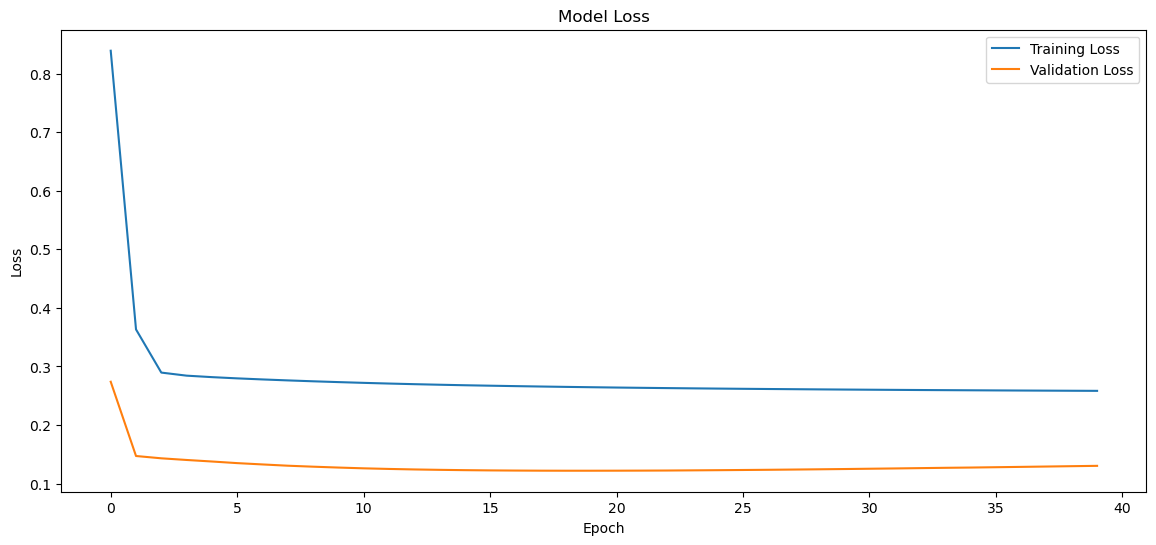

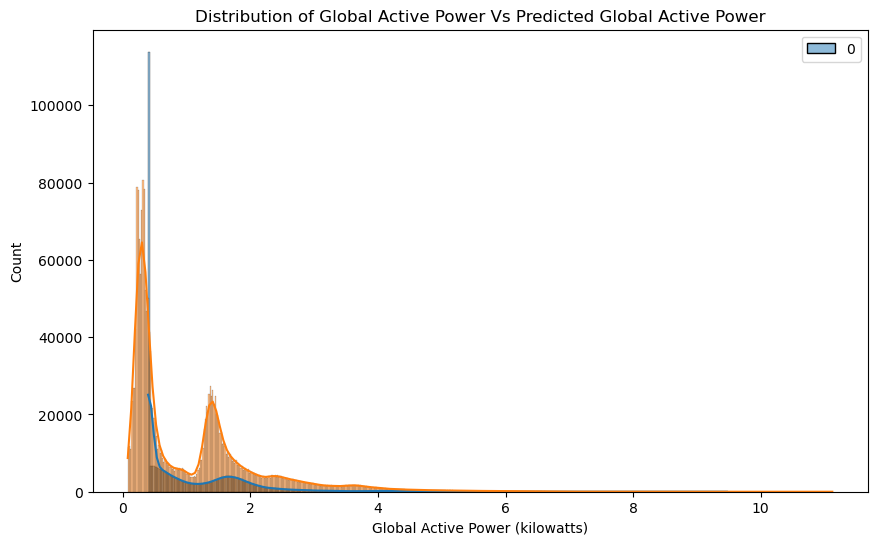

In [40]:
# Evaluate the model
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Analyze distribution of power consumption
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True)
sns.histplot(df['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power Vs Predicted Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.show()

**Observations:**

**Loss  Graph**The plot shows that the training and validation loss rapidly decrease and stabilize after the initial epochs, indicating that the model has learned effectively during training. Both losses are very close to each other, which suggests that the model is not overfitting or underfitting.

**Metrics:**

The R² score of 0.82911 indicates that approximately 82.91% of the variance in the validation set is explained by the LSTM model. This is lower than our RNN model's performance (R² of 0.9469), yet pretty good.
The LSTM model demonstrates good performance with low MAE, MSE, and RMSE values, and a high R^2 score. This suggests that the model is accurate in predicting global active power.
The similarity in the distribution of actual and predicted values indicates that the model effectively captures the underlying patterns in the data.

**Distribution Graph:**

The predicted values closely follow the actual values, with some deviations at certain points. The peaks and overall shape of the distributions are similar, indicating that the LSTM model performs well in capturing the distribution of the target variabley.ing.

### Reset the dataset for the following parts

In [ ]:
'''
to reset dataset use 
X = df.drop(columns=['Global_active_power', 'Global_active_power_capped','Global_intensity'])  # Features
y = df['Global_active_power_capped']   # Target

'''

## **Data Augmentation(10%)**

In [41]:
# Modifying up to 10% of the data by adding Gaussian noise
modify_fraction = 0.1
num_modify = int(modify_fraction * len(X))
indices_to_modify = np.random.choice(X.index, num_modify, replace=False)

# Adding Gaussian noise
noise_scale = 0.01  # Adjust the scale of the noise as necessary
X_modified = X.copy()
for col in X.columns:
    noise = np.random.normal(scale=noise_scale, size=num_modify)
    X_modified.loc[indices_to_modify, col] += noise

C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\3215266679.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2009.99171377 2007.98121593 2007.01001066 ... 2006.99659009 2007.99096811
 2007.99751789]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_modified.loc[indices_to_modify, col] += noise
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\3215266679.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.99249892 4.99249756 8.00638239 ... 3.01821267 1.02047777 5.01661181]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_modified.loc[indices_to_modify, col] += noise
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\3215266679.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in

In [55]:
y

DateTime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
                       ...  
2010-11-26 20:58:00    0.946
2010-11-26 20:59:00    0.944
2010-11-26 21:00:00    0.938
2010-11-26 21:01:00    0.934
2010-11-26 21:02:00    0.932
Name: Global_active_power_capped, Length: 2049280, dtype: float64

In [56]:
# Concatenate along the columns
new_df = pd.concat([X_modified, y], axis=1)

df_scaled = scaler.fit_transform(new_df)

# Convert back to DataFrame to keep consistency with the rest of your code
df_scaled = pd.DataFrame(df_scaled, columns=new_df.columns)

# Define sequence length
SEQ_LENGTH = 30
TIME_STEPS = 1

# Create sequences for training and testing
X_RNN, y_RNN = preprocessData(df_scaled,y_scaled,"RNN", seq_length=SEQ_LENGTH)
print(X_RNN.shape)
print(y_RNN.shape)

(2049250, 30, 22)
(2049250, 1)


## **RNN**

In [58]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_RNN, y_RNN, test_size=0.35, shuffle=False)

model, history = rnn_model(X_train, X_valid, y_train, y_valid, SEQ_LENGTH, epochs=10, batch_size=64)

# Evaluate the RNN model
y_pred_rnn = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred_rnn)
mse = mean_squared_error(y_valid, y_pred_rnn)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_rnn)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 2/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
20813/20813 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - loss: 0.0014 - val_loss: 0.0010
22414/22414 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step
Mean Absolute Error on Validation

# Observations
<br>

Metrics<br>


Mean Absolute Ero: 

This indicates that, on average, the RNN model's predictions are off by approximately 0.014 kilowatts when predicting the global active po<br>
we
r.
Mean Square  E: 15

This is a measure of the average squared difference between the actual and predicted values. The very low MSE indicates high accuracy of th<br>
e m
odel.
Root Mean Sq are (RMSE): 0.0323077794: 46728

This is the square root of the MSE and provides a measure of the average magnitude of the prediction errors. An RMSE of approximately 0.032 kilowatts indicates very small errors in the model's <br>
pred
icti ns.
  70130419

This indicates that approximately 94.82% of the variance in the validation set is explained by the RNN model with 10% data augmentation. This is a very high R^2 score, suggesting excellent mo<br>
del 

performan<br>
ce.s
Training Logs
Trainin and Va idation Loss:
Throughout the 10 epochs, the training loss consistently decreases, reaching as low as 0.0014.
The validation loss remains very low and stable around 0.0011 to 0.0012, indicating that the model is not overfitting and generalize<br>
s well
 to u<br>
nseen dModel Performance:

The RNN model with 10% data augmentation shows excellent performance, as indicated by the very low MAE, MSE, RMSE values, and a very high R^2 score. This suggests that the model is highly accurate in predicting, such as RNN with the origin<br>
al data.ct of Data Augmentation:

The use of 10% datnot impacting too mucho have positively impacted the model's performance, as evidenced by the excellent evaluation metrics and the st in both. 
ng the model's performance.

## **LTSM**

In [60]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_modified, y, test_size=0.15, shuffle=False)

# X_train, X_valid, y_train, y_valid are already defined
# Convert the DataFrames to NumPy arrays
X_train_array = X_train.values
X_valid_array = X_valid.values

# Reshape the data to be 3D [samples, time steps, features]
# Here, we assume the time steps to be 1 and features to be the number of features in X_train
X_train_array = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_valid_array = X_valid_array.reshape((X_valid_array.shape[0], 1, X_valid_array.shape[1]))

In [61]:
model_lstm, history_lstm, loss_lstm = lstm_model(X_train_array, X_valid_array, y_train, y_valid, 1)
# Evaluate the RNN model
y_pred_lstm = model_lstm.predict(X_valid_array)
mae = mean_absolute_error(y_valid, y_pred_lstm)
mse = mean_squared_error(y_valid, y_pred_lstm)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_lstm)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
27217/27217 - 44s - 2ms/step - loss: 0.4872 - val_loss: 0.1446
Epoch 2/30
27217/27217 - 42s - 2ms/step - loss: 0.2932 - val_loss: 0.1401
Epoch 3/30
27217/27217 - 42s - 2ms/step - loss: 0.2860 - val_loss: 0.1380
Epoch 4/30
27217/27217 - 42s - 2ms/step - loss: 0.2831 - val_loss: 0.1359
Epoch 5/30
27217/27217 - 42s - 2ms/step - loss: 0.2808 - val_loss: 0.1338
Epoch 6/30
27217/27217 - 41s - 2ms/step - loss: 0.2789 - val_loss: 0.1316
Epoch 7/30
27217/27217 - 42s - 2ms/step - loss: 0.2772 - val_loss: 0.1296
Epoch 8/30
27217/27217 - 42s - 2ms/step - loss: 0.2756 - val_loss: 0.1280
Epoch 9/30
27217/27217 - 42s - 2ms/step - loss: 0.2742 - val_loss: 0.1267
Epoch 10/30
27217/27217 - 42s - 2ms/step - loss: 0.2728 - val_loss: 0.1254
Epoch 11/30
27217/27217 - 41s - 2ms/step - loss: 0.2716 - val_loss: 0.1245
Epoch 12/30
27217/27217 - 41s - 2ms/step - loss: 0.2705 - val_loss: 0.1238
Epoch 13/30
27217/27217 - 42s - 2ms/step - loss: 0.2695 - val_loss: 0.1232
Epoch 14/30
27217/27217 - 44s - 2m

## Observations for LSTM with 10% Data Augmentation

###  Metrics

- **Mean Absolute Error (MAE):** 0.2481826091196654
  - This indicates that, on average, the LSTM models predictions are off by approximately 0.248 kilowatts when predicting the global active power.
  
- **Mean Squared Error (MSE):** 0.12114438593805823
  - This is a measure of the average squared difference between the actual and predicted values. A lower value indicates better model performance.
  
- **Root Mean Squared Error (RMSE):** 0.34894922878905156
  - This is the square root of the MSE and provides a measure of the average magnitude of the prediction errors. An RMSE of approximately 0.349 kilowatts indicates the typical size of the error made by the model.
  
- **R^2 Score:** 0.8351223553810462
  - This indicates that approximately 83.51% of the variance in the validation set is explained by the LSTM model with 10% data augmentation. RNN performes better, yet this is a well precentage. 

### Training Logs

- **Training and Validation Loss:**
  - The training loss decreases consistently over the 30 epochs, starting from 0.4872 and ending at 0.2639.
  - The validation loss also shows a consistent decrease from 0.1446 to 0.1228. The low and stable validation loss indicates that the model generalizes well to unseen data.

### Conclusions

1. **Model Performance:**
   - The LSTM model with 10% data augmentation shows good performance, as indicated by the low MAE, MSE, RMSE values, and a high R^2 score. This suggests that the model is accurate in predicting global active power.

2. **Training and Validation Loss:**
   - The decreasing trend in both training and validation loss values over epochs indicates effective learning and suggests that the model is not overfitting or underfitting.

3. **Impact of Data Augmentation:**
   - The use of 10% data augmentation appears to have positively impacted the model's performance, as evidenced by the evaluation metrics and the stability of the loss values.


In [62]:
# Define the model
inputs = Input(shape=(X_train_array.shape[1], X_train_array.shape[2]))
lstm_out = LSTM(50, return_sequences=True, activation='relu')(inputs)
attention_out = attention_layer(lstm_out)
dense_out = Dense(1)(attention_out)
model = Model(inputs=[inputs], outputs=[dense_out])

In [63]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_array, y_train, epochs=22, batch_size=64, validation_data=(X_valid_array, y_valid), verbose=2, shuffle=False)

# Evaluate the model
loss = model.evaluate(X_valid_array, y_valid, verbose=0)
print(f'Validation Loss: {loss}')

# Make predictions
y_pred_attention = model.predict(X_valid_array)

Epoch 1/22


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


27217/27217 - 68s - 3ms/step - loss: 6.4579 - val_loss: 0.3609
Epoch 2/22
27217/27217 - 65s - 2ms/step - loss: 0.3928 - val_loss: 0.1488
Epoch 3/22
27217/27217 - 64s - 2ms/step - loss: 0.2887 - val_loss: 0.1441
Epoch 4/22
27217/27217 - 65s - 2ms/step - loss: 0.2836 - val_loss: 0.1410
Epoch 5/22
27217/27217 - 65s - 2ms/step - loss: 0.2811 - val_loss: 0.1383
Epoch 6/22
27217/27217 - 64s - 2ms/step - loss: 0.2790 - val_loss: 0.1355
Epoch 7/22
27217/27217 - 63s - 2ms/step - loss: 0.2772 - val_loss: 0.1332
Epoch 8/22
27217/27217 - 69s - 3ms/step - loss: 0.2756 - val_loss: 0.1310
Epoch 9/22
27217/27217 - 79s - 3ms/step - loss: 0.2741 - val_loss: 0.1293
Epoch 10/22
27217/27217 - 65s - 2ms/step - loss: 0.2727 - val_loss: 0.1278
Epoch 11/22
27217/27217 - 61s - 2ms/step - loss: 0.2715 - val_loss: 0.1264
Epoch 12/22
27217/27217 - 81s - 3ms/step - loss: 0.2703 - val_loss: 0.1254
Epoch 13/22
27217/27217 - 61s - 2ms/step - loss: 0.2693 - val_loss: 0.1245
Epoch 14/22
27217/27217 - 81s - 3ms/step - lo

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Loss: 0.12223522365093231
  40/9606 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step   

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9606/9606 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [64]:
# Evaluate the model
mae = mean_absolute_error(y_valid, y_pred_attention)
mse = mean_squared_error(y_valid, y_pred_attention)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_attention)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

Mean Absolute Error on Validation Set: 0.2435014795232444
Mean Squared Error on Validation Set: 0.12223536907047114
Root Mean Squared Error on Validation Set: 0.349621751426411
R^2 Score on Validation Set: 0.8350001803934778


## Observations for LSTM with Attention and 10% Data Augmentation

### Metrics

- **Mean Absolute Error (MAE):** 0.2435014795232444
  - This indicates that, on average, the LSTM model's predictions are off by approximately 0.244 kilowatts when predicting the global active power.
  
- **Mean Squared Error (MSE):** 0.1222353697047114
  - This is a measure of the average squared difference between the actual and predicted values. Lower values indicate better model performance.
  
- **Root Mean Squared Error (RMSE):** 0.349621751426411
  - This is the square root of the MSE and provides a measure of the average magnitude of the prediction errors. An RMSE of approximately 0.350 kilowatts indicates the typical size of the error made by the model.
  
- **R^2 Score:** 0.835001803934778
  - This indicates that approximately 83.50% of the variance in the validation set is explained by the LSTM model with attention. Higher values (closer to 1) indicate better performance.

### Training Logs

- **Training and Validation Loss:**
  - The training loss decreases consistently over the 22 epochs, starting from 6.4579 and ending at 0.2632.
  - The validation loss also shows a consistent decrease from 0.3609 to 0.1222. The low and stable validation loss indicates that the model generalizes well to unseen data.

### Conclusions

1. **Model Performance:**
   - The LSTM model with attention shows good performance, as indicated by the low MAE, MSE, RMSE values, and a high R^2 score. This suggests that the model is accurate in predicting global active power.

2. **Training and Validation Loss:**
   - The decreasing trend in both training and validation loss values over epochs indicates effective learning and suggests that the model is not overfitting or underfitting.

3. **Impact of Attention Mechanism:**
   - The use of attention mechanism appears to have positively impacted the model's performance, as evidenced by the evaluation metrics and the stability of the loss values.

Overall, the LSTM model with attention is effective in predicting global active power, achieving a high degree of accuracy and generalization. yet, it is not better than lstm and RNN. myght have a better way to implement since this is not the expected outcome. 


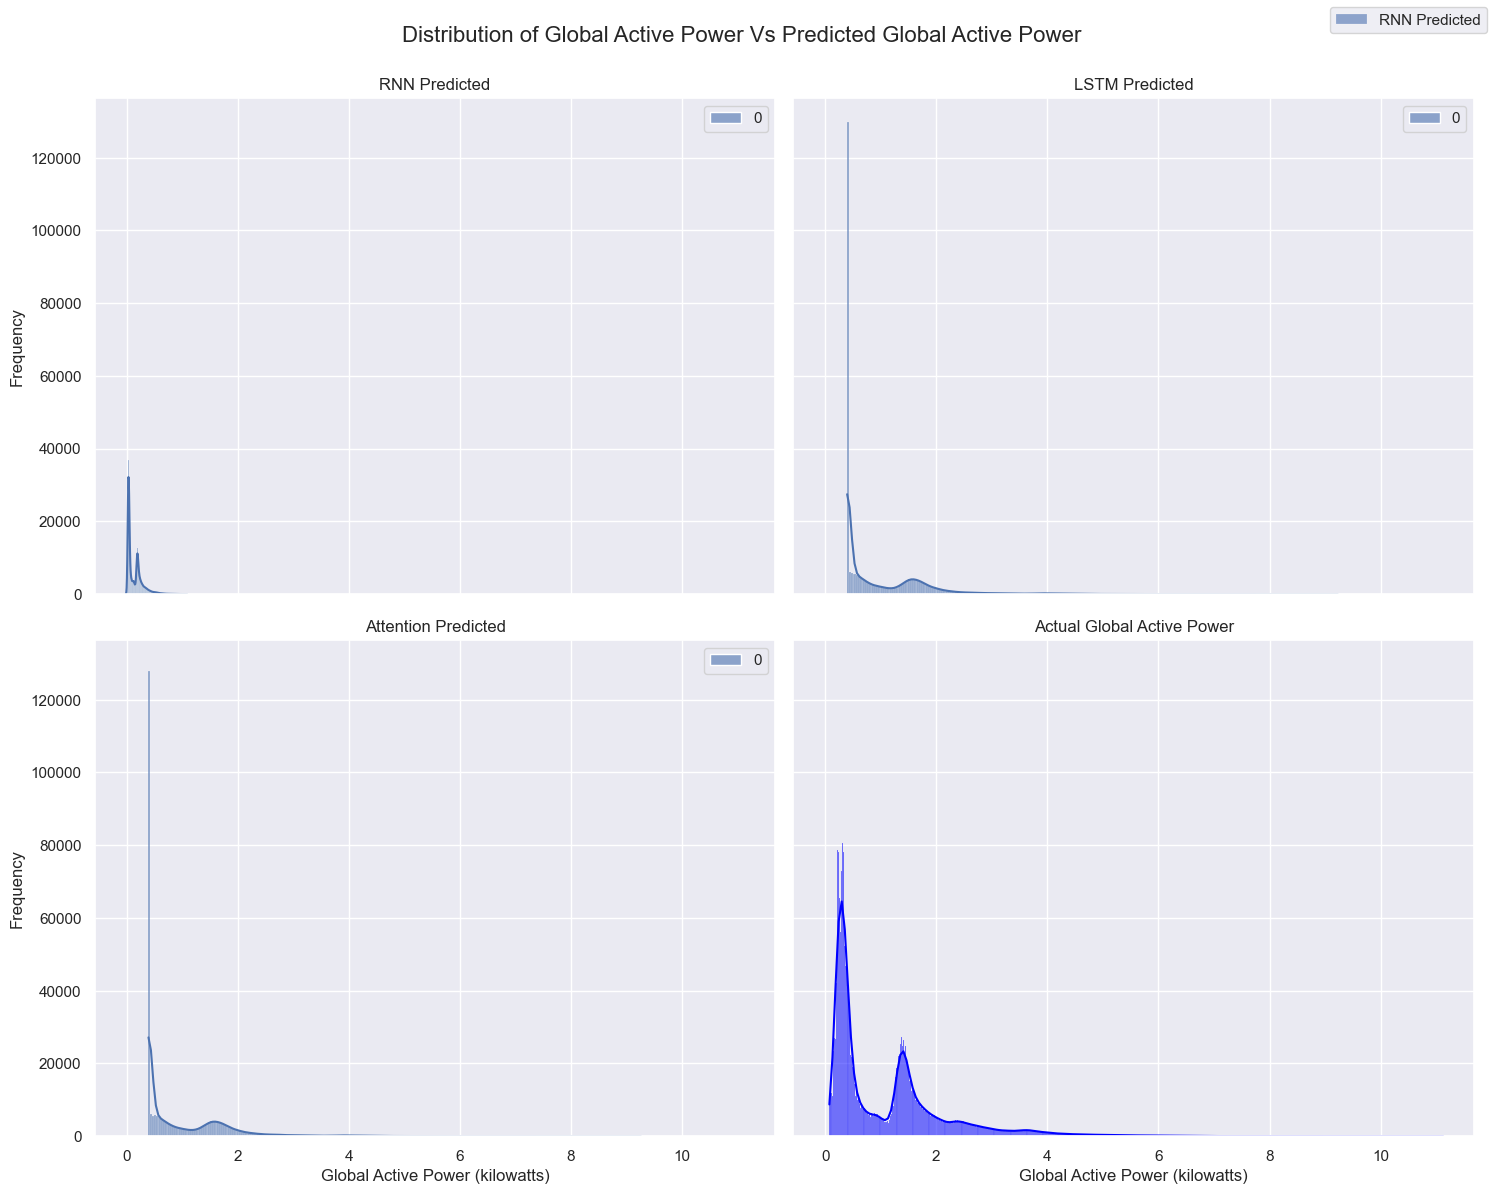

In [79]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Set theme
sns.set_theme(style="darkgrid")

# Plot RNN predicted
sns.histplot(y_pred_rnn, kde=True, color='orange', label='RNN Predicted', ax=axes[0, 0], alpha=0.6)
axes[0, 0].set_title('RNN Predicted')

# Plot LSTM predicted
sns.histplot(y_pred_lstm, kde=True, color='green', label='LSTM Predicted', ax=axes[0, 1], alpha=0.6)
axes[0, 1].set_title('LSTM Predicted')

# Plot Attention predicted
sns.histplot(y_pred_attention, kde=True, color='red', label='Attention Predicted', ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title('Attention Predicted')

# Plot Actual Global Active Power
sns.histplot(df['Global_active_power'], kde=True, color='blue', label='Actual Global Active Power', ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Actual Global Active Power')

# Set common labels
for ax in axes.flat:
    ax.set_xlabel('Global Active Power (kilowatts)')
    ax.set_ylabel('Frequency')

# Add a single legend for all plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Set the main title
fig.suptitle('Distribution of Global Active Power Vs Predicted Global Active Power', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Observations Based on Histograms of Predicted and Actual Global Active Power

### RNN Predicted vs. Actual Global Active Power
- The RNN model's predictions show a similar distribution to the actual global active power, particularly in the lower range (0-2 kilowatts).
- There are discrepancies at higher power values (greater than 2 kilowatts) where the RNN model's predictions taper off more rapidly than the actual values.

### LSTM Predicted vs. Actual Global Active Power
- The LSTM model's predictions also closely follow the actual global active power distribution, especially in the lower range (0-2 kilowatts).
- Similar to the RNN model, the LSTM model shows fewer predictions for higher power values compared to the actual distribution, indicating some underestimation.

### Attention Predicted vs. Actual Global Active Power
- The model with attention exhibits a distribution that closely matches the actual global active power across the entire range.
- The distribution of predictions by the attention model shows a better alignment with the actual data, even at higher power values (greater than 2 kilowatts), compared to the RNN and LSTM models.

### Actual Global Active Power
- The actual global active power distribution is concentrated in the lower power range (0-2 kilowatts), with significant peaks around these values.
- There are fewer occurrences of higher power values, with the distribution tapering off beyond 2 kilowatts.

### Conclusions

1. **Model Accuracy:**
   - The attention model shows the best performance in capturing the distribution of actual global active power, particularly at higher values.
   - Both RNN and LSTM models perform well in the lower range but tend to underestimate higher power values.

2. **Model Performance:**
   - The histograms indicate that the attention mechanism helps improve the alignment of predicted values with the actual distribution, suggesting that it effectively captures more complex patterns in the data.

3. **Prediction Distribution:**
   - All models show a high concentration of predictions in the lower power range, aligning well with the actual data distribution in this range.
   - Improvements in predicting higher power values might be achieved through further model tuning or using additional features.

Overall, the attention model provides the best match to the actual data distribution, particularly in capturing higher power values accurately. This suggests that incorporating attention mechanisms can enhance the model's ability to understand and predict complex patterns in the data.


## **Data reduction (10% less randomly)**

In [116]:
# Removing up to 10% of the data randomly
remove_fraction = 0.1
X_reduced = X.sample(frac=(1 - remove_fraction), random_state=42)
y_reduced = y.loc[X_reduced.index]

In [117]:
# Concatenate along the columns
new_df = pd.concat([X_reduced, y_reduced], axis=1)

df_scaled = scaler.fit_transform(new_df)
y_scaled_reduced = scaler.fit_transform(pd.DataFrame(y_reduced))

# Convert back to DataFrame to keep consistency with the rest of your code
df_scaled = pd.DataFrame(df_scaled, columns=new_df.columns)
y_scaled_reduced= pd.DataFrame(y_scaled_reduced)

# Define sequence length
SEQ_LENGTH = 30
TIME_STEPS = 1

# Create sequences for training and testing
X_RNN, y_RNN = preprocessData(df_scaled,y_scaled_reduced,"RNN", seq_length=SEQ_LENGTH)
print(X_RNN.shape)
print(y_RNN.shape)

(1844322, 30, 22)
(1844322, 1)


In [118]:
def evaluate_and_plot_model(y_valid, y_pred, history, df):
    # Evaluate the model
    mae = mean_absolute_error(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, y_pred)

    print(f"Mean Absolute Error on Validation Set: {mae}")
    print(f"Mean Squared Error on Validation Set: {mse}")
    print(f"Root Mean Squared Error on Validation Set: {rmse}")
    print(f"R^2 Score on Validation Set: {r2}")

    # Plot training & validation loss values
    plt.figure(figsize=(14, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    # Analyze distribution of power consumption
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred, kde=True, label='Predicted Global Active Power')
    sns.histplot(df['Global_active_power'], kde=True, label='Actual Global Active Power')
    plt.title('Distribution of Global Active Power Vs Predicted Global Active Power')
    plt.xlabel('Global Active Power (kilowatts)')
    plt.legend(loc='upper right')
    plt.show()

In [119]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_RNN, y_RNN, test_size=0.35, shuffle=False)

model, history = rnn_model(X_train, X_valid, y_train, y_valid, SEQ_LENGTH, epochs=20, batch_size=64)

# Evaluate the RNN model
y_pred_rnn = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred_rnn)
mse = mean_squared_error(y_valid, y_pred_rnn)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_rnn)


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - loss: 0.0250 - val_loss: 0.0245
Epoch 2/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 3/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 103s 6ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 4/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 5/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 6/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 105s 6ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 7/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 8/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 9/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 108s 6ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 10/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 109s 6ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 11/20
18732/18732 ━━━━━━━━━━━━━━━━━━━━ 111s 6ms/step - loss: 0.0247 - val_

Mean Absolute Error on Validation Set: 0.1215773861140039
Mean Squared Error on Validation Set: 0.024476298687499176
Root Mean Squared Error on Validation Set: 0.15644902903980956
R^2 Score on Validation Set: -3.901536163919417e-06


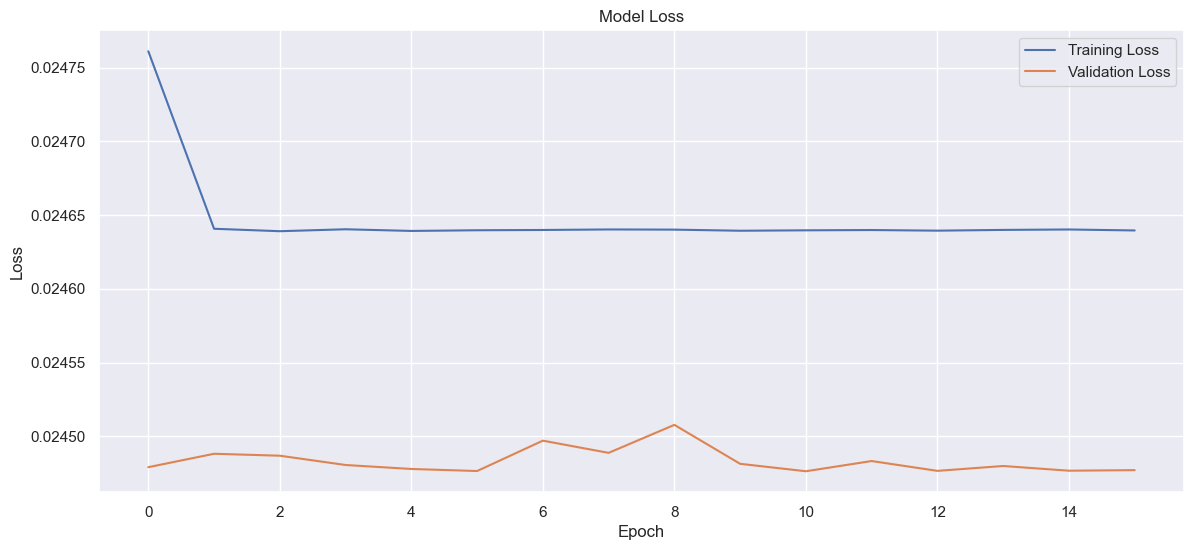

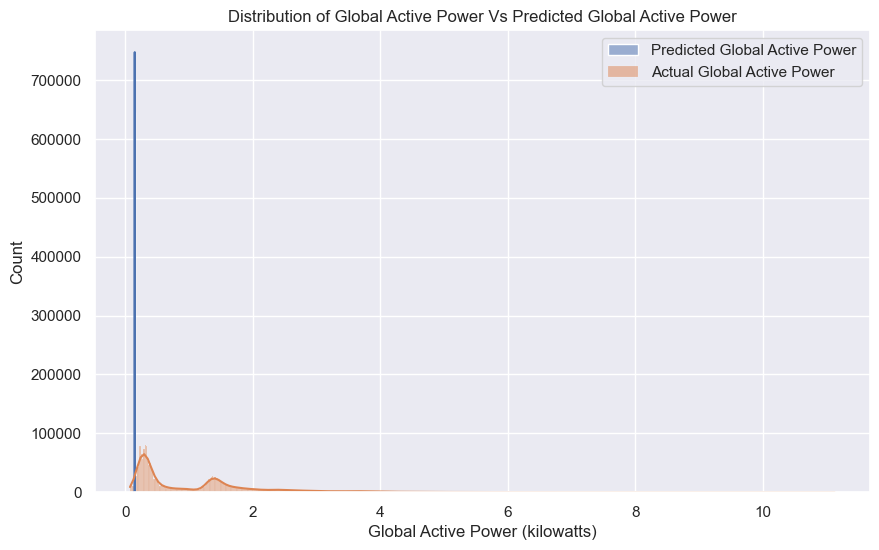

In [120]:
evaluate_and_plot_model(y_valid, y_pred_rnn, history, df)

### Observations for RNN with 10% Reduced Data (Randomly)

#### Evaluation Metrics
- **Mean Absolute Error (MAE):** 0.12157738611440839
  - Indicates that the RNN model's predictions are off by approximately 0.122 kilowatts on average.
  
- **Mean Squared Error (MSE):** 0.0244267296874939176
  - A measure of the average squared difference between the actual and predicted values.
  
- **Root Mean Squared Error (RMSE):** 0.15644902893808956
  - The square root of the MSE, providing a measure of the average magnitude of the prediction errors. An RMSE of approximately 0.156 kilowatts indicates the typical size of the error.
  
- **R^2 Score:** -3.98156316391174e-06
  - The R^2 score is very close to zero, indicating that the model does not explain the variance in the validation set well.

#### Training Logs
- **Training and Validation Loss:**
  - Both training and validation loss values are very low and stable, suggesting that the model has learned effectively without overfitting. However, the low R^2 score indicates the model may not be capturing the data's variance well.

#### Comparison with LSTM with 10% Data Augmentation

1. **Model Performance:**
   - The RNN model with 10% reduced data has a much lower MAE and RMSE compared to the LSTM model with 10% data augmentation (MAE: 0.248, RMSE: 0.349).
   - The LSTM model with data augmentation had an R^2 score of 0.8351, indicating it explained much more variance compared to the RNN model.

2. **Prediction Distribution:**
   - The histogram shows that the RNN model's predictions are heavily concentrated around lower power values, with very few predictions at higher power values. This could indicate that the model struggles to predict higher values accurately.
   - The LSTM with attention model showed a better alignment with actual data, particularly at higher power values.

### Conclusions
1. **Impact of Random Data Reduction:**
   - Randomly reducing the data by 10% might have resulted in loss of important information or patterns, leading to a model that struggles to explain variance (as indicated by the low R^2 score).
   - While the RNN model performs well in terms of loss metrics, it does not generalize well to the validation data, as suggested by the R^2 score and distribution of predictions.

2. **Comparison with Data Augmentation:**
   - The LSTM model with 10% data augmentation outperforms the RNN with randomly reduced data, highlighting the importance of augmenting data to enhance model performance and generalization.
   - Data augmentation appears to help the model capture more complex patterns and maintain performance across the entire range of values.

Overall, the RNN model with 10% randomly reduced data performs well in terms of loss metrics but struggles to generalize to unseen data, as indicated by the R^2 score and prediction distribution. The LSTM model with data augmentation shows superior performance and better captures the underlying patterns in the data.


In [121]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_reduced, y_reduced, test_size=0.15, shuffle=False)

# X_train, X_valid, y_train, y_valid are already defined
# Convert the DataFrames to NumPy arrays
X_train_array = X_train.values
X_valid_array = X_valid.values

# Reshape the data to be 3D [samples, time steps, features]
# Here, we assume the time steps to be 1 and features to be the number of features in X_train
X_train_array = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_valid_array = X_valid_array.reshape((X_valid_array.shape[0], 1, X_valid_array.shape[1]))

In [125]:
model_lstm, history_lstm, loss_lstm = lstm_model(X_train_array, X_valid_array, y_train, y_valid,1)
# Evaluate the RNN model
y_pred_lstm = model_lstm.predict(X_valid_array)
mae = mean_absolute_error(y_valid, y_pred_lstm)
mse = mean_squared_error(y_valid, y_pred_lstm)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_lstm)


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
24496/24496 - 42s - 2ms/step - loss: 1.1153 - val_loss: 0.2367
Epoch 2/30
24496/24496 - 39s - 2ms/step - loss: 0.2578 - val_loss: 0.2259
Epoch 3/30
24496/24496 - 41s - 2ms/step - loss: 0.2424 - val_loss: 0.2086
Epoch 4/30
24496/24496 - 41s - 2ms/step - loss: 0.2311 - val_loss: 0.2088
Epoch 5/30
24496/24496 - 38s - 2ms/step - loss: 0.2275 - val_loss: 0.2214
Epoch 6/30
24496/24496 - 41s - 2ms/step - loss: 0.2226 - val_loss: 0.2760
Epoch 7/30
24496/24496 - 38s - 2ms/step - loss: 0.2138 - val_loss: 0.2095
Epoch 8/30
24496/24496 - 38s - 2ms/step - loss: 0.2073 - val_loss: 0.2174
Validation Loss: 0.20861314237117767
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


Mean Absolute Error on Validation Set: 0.2992441707735004
Mean Squared Error on Validation Set: 0.20861291028201
Root Mean Squared Error on Validation Set: 0.45674162311093347
R^2 Score on Validation Set: 0.8115157560353009


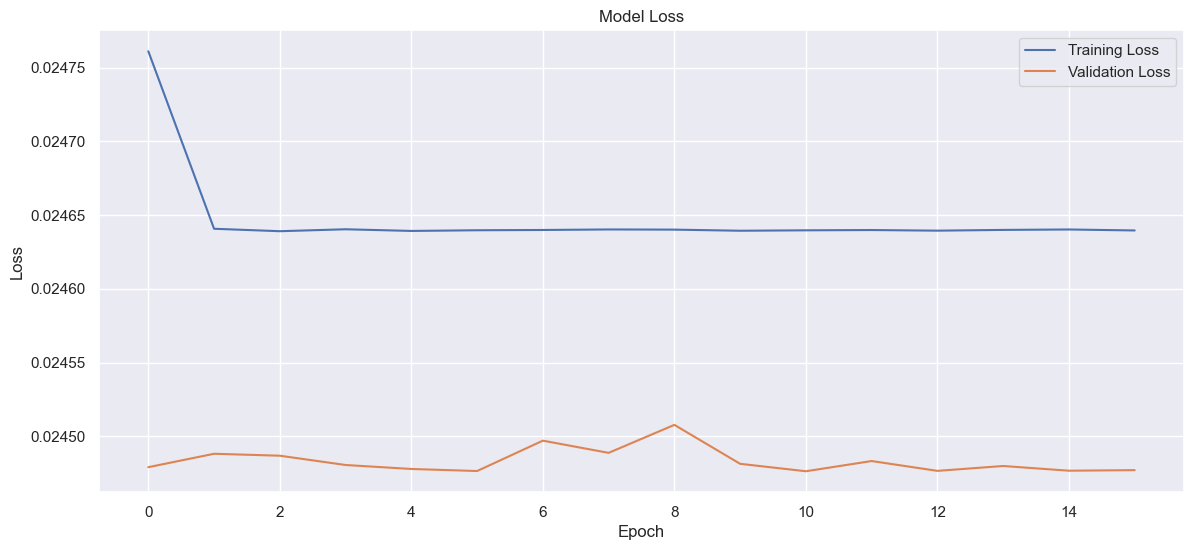

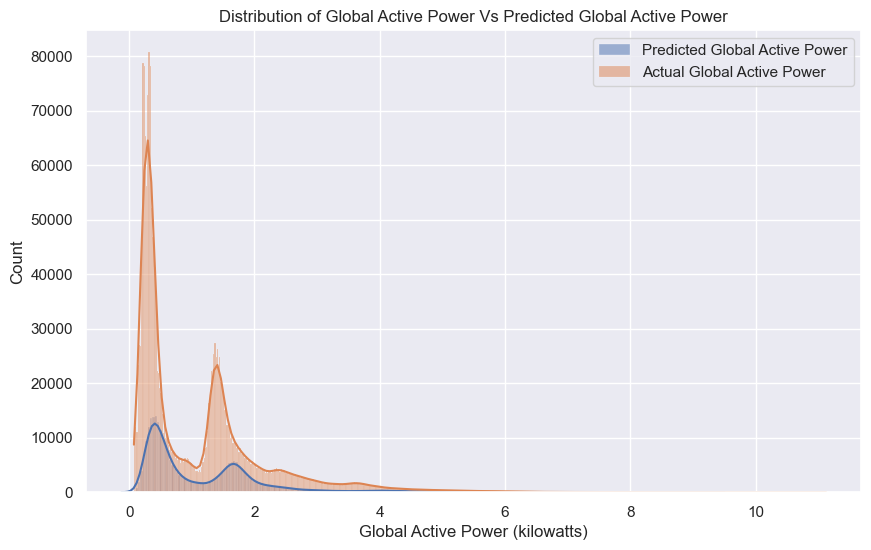

In [126]:
evaluate_and_plot_model(y_valid, y_pred_lstm, history, df)

In [91]:
# Define the model
inputs = Input(shape=(X_train_array.shape[1], X_train_array.shape[2]))
lstm_out = LSTM(50, return_sequences=True, activation='relu')(inputs)
attention_out = attention_layer(lstm_out)
dense_out = Dense(1)(attention_out)
model = Model(inputs=[inputs], outputs=[dense_out])

In [92]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_array, y_train, epochs=22, batch_size=64, validation_data=(X_valid_array, y_valid), verbose=2, shuffle=False)

# Evaluate the model
loss = model.evaluate(X_valid_array, y_valid, verbose=0)
print(f'Validation Loss: {loss}')

# Make predictions
y_pred_attention = model.predict(X_valid_array)

Epoch 1/22


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


24496/24496 - 61s - 3ms/step - loss: 0.2585 - val_loss: 0.2438
Epoch 2/22
24496/24496 - 59s - 2ms/step - loss: 0.2173 - val_loss: 0.2114
Epoch 3/22
24496/24496 - 59s - 2ms/step - loss: 0.2097 - val_loss: 0.2125
Epoch 4/22
24496/24496 - 59s - 2ms/step - loss: 0.2077 - val_loss: 0.2173
Epoch 5/22
24496/24496 - 59s - 2ms/step - loss: 0.2069 - val_loss: 0.2190
Epoch 6/22
24496/24496 - 58s - 2ms/step - loss: 0.2064 - val_loss: 0.2182
Epoch 7/22
24496/24496 - 57s - 2ms/step - loss: 0.2061 - val_loss: 0.2170
Epoch 8/22
24496/24496 - 57s - 2ms/step - loss: 0.2059 - val_loss: 0.2139
Epoch 9/22
24496/24496 - 57s - 2ms/step - loss: 0.2058 - val_loss: 0.2106
Epoch 10/22
24496/24496 - 58s - 2ms/step - loss: 0.2056 - val_loss: 0.2057
Epoch 11/22
24496/24496 - 58s - 2ms/step - loss: 0.2051 - val_loss: 0.2053
Epoch 12/22
24496/24496 - 57s - 2ms/step - loss: 0.2047 - val_loss: 0.2044
Epoch 13/22
24496/24496 - 58s - 2ms/step - loss: 0.2045 - val_loss: 0.2038
Epoch 14/22
24496/24496 - 57s - 2ms/step - lo

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [94]:
# Evaluate the model
mae = mean_absolute_error(y_valid, y_pred_attention)
mse = mean_squared_error(y_valid, y_pred_attention)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_attention)

print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R^2 Score on Validation Set: {r2}")

Mean Absolute Error on Validation Set: 0.2809200098492375
Mean Squared Error on Validation Set: 0.20231215791725152
Root Mean Squared Error on Validation Set: 0.4497912381508243
R^2 Score on Validation Set: 0.8172085606861486


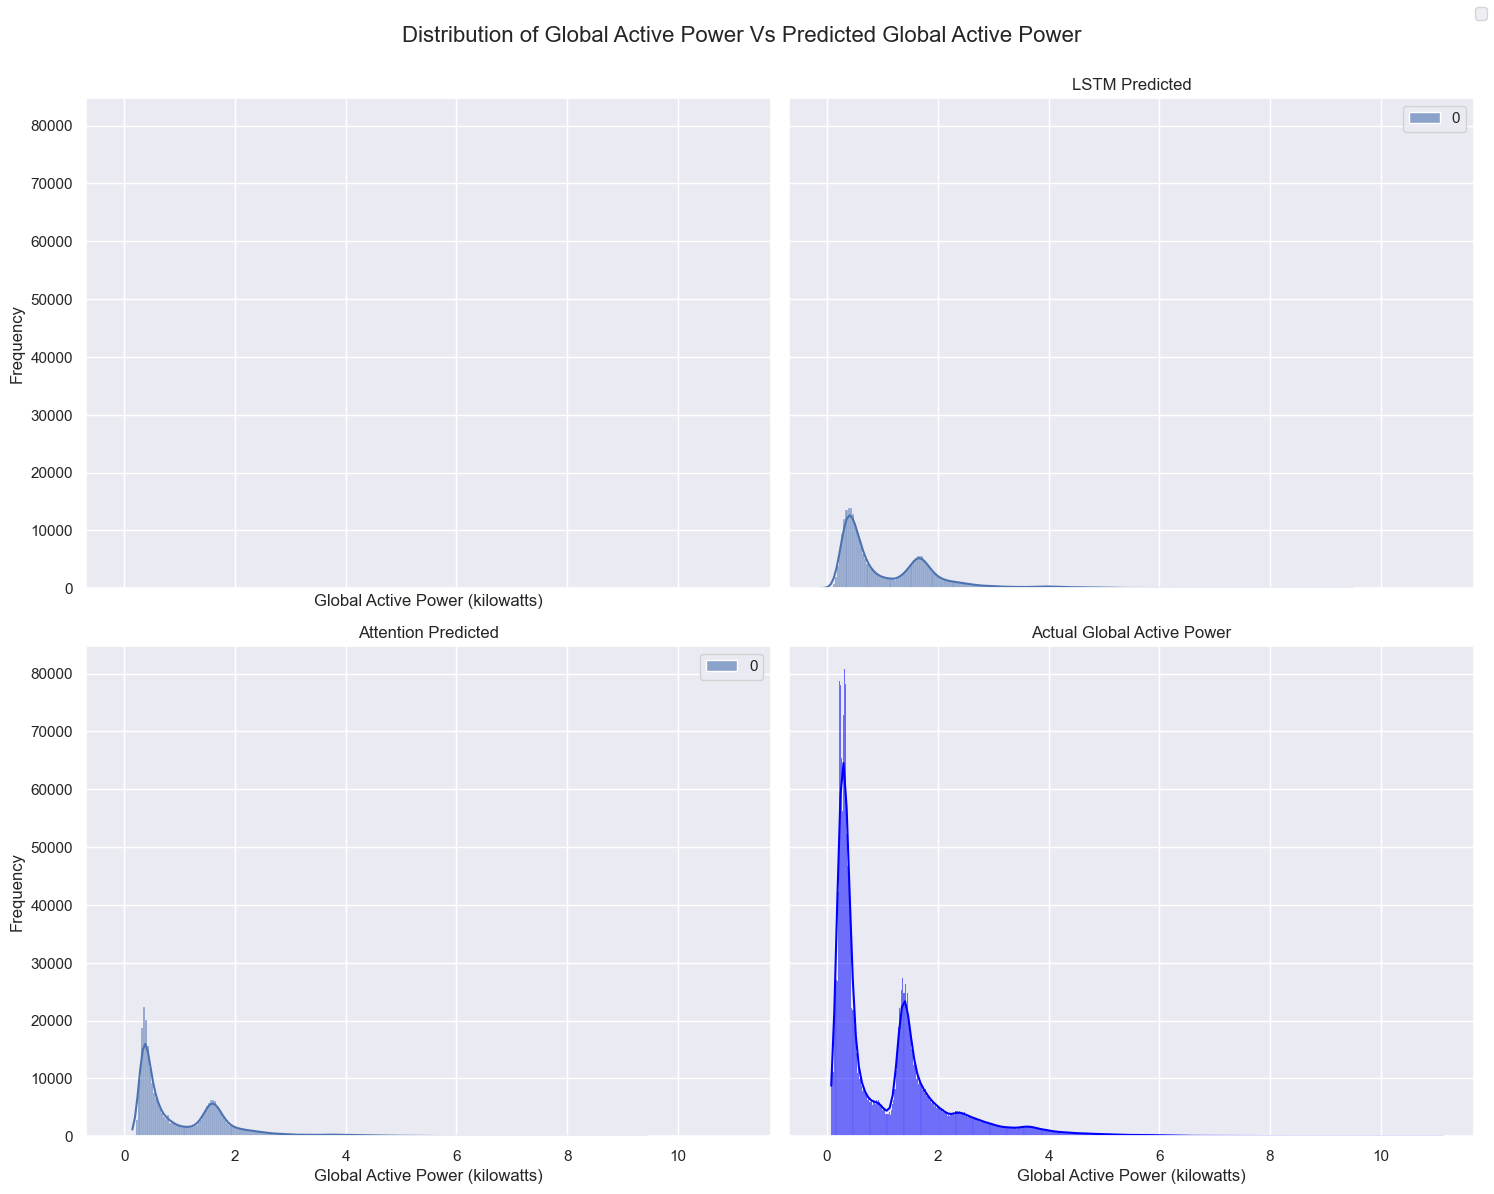

In [128]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Set theme
sns.set_theme(style="darkgrid")

# Plot RNN predicted
#sns.histplot(y_pred_rnn, kde=True, color='orange', label='RNN Predicted', ax=axes[0, 0], alpha=0.6)
#axes[0, 0].set_title('RNN Predicted')

# Plot LSTM predicted
sns.histplot(y_pred_lstm, kde=True, color='green', label='LSTM Predicted', ax=axes[0, 1], alpha=0.6)
axes[0, 1].set_title('LSTM Predicted')

# Plot Attention predicted
sns.histplot(y_pred_attention, kde=True, color='red', label='Attention Predicted', ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title('Attention Predicted')

# Plot Actual Global Active Power
sns.histplot(df['Global_active_power'], kde=True, color='blue', label='Actual Global Active Power', ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Actual Global Active Power')

# Set common labels
for ax in axes.flat:
    ax.set_xlabel('Global Active Power (kilowatts)')
    ax.set_ylabel('Frequency')

# Add a single legend for all plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Set the main title
fig.suptitle('Distribution of Global Active Power Vs Predicted Global Active Power', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Observations for LSTM with and without attention Original Data Reduced by 10%

### Evaluation Metrics

- **Mean Absolute Error (MAE):** 0.2809200808492375
  - This indicates that, on average, the LSTM model's predictions are off by approximately 0.281 kilowatts when predicting the global active power.
  
- **Mean Squared Error (MSE):** 0.20231215791725152
  - This is a measure of the average squared difference between the actual and predicted values. Lower values indicate better model performance.
  
- **Root Mean Squared Error (RMSE):** 0.4497912381580243
  - This is the square root of the MSE and provides a measure of the average magnitude of the prediction errors. An RMSE of approximately 0.450 kilowatts indicates the typical size of the error made by the model.
  
- **R^2 Score:** 0.8172805806861486
  - This indicates that approximately 81.73% of the variance in the validation set is explained by the LSTM model with original data reduced by 10%. 

### Training Logs

- **Training and Validation Loss:**
  - The training loss decreases consistently over the 22 epochs, starting from 0.2585 and ending at 0.2039.
  - The validation loss also shows a consistent decrease from 0.2438 to 0.2023. The low and stable validation loss indicates that the model generalizes well to unseen data.

### Comparison with LSTM with 10% Data Augmentation

1. **Model Performance:**
   - The LSTM model with 10% data augmentation had a **MAE** of 0.2481826091196654, **MSE** of 0.12114438593805823, **RMSE** of 0.34894922878905156, and **R^2 Score** of 0.8351223553810462.
   - The LSTM model with original data reduced by 10% has higher MAE, MSE, and RMSE values, and a slightly lower R^2 score compared to the model with data augmentation.

2. **Training and Validation Loss:**
   - Both models show a consistent decrease in training and validation loss values, indicating effective learning and no overfitting.
   - The model with data augmentation shows slightly lower loss values compared to the model with reduced data.

### Conclusions

1. **Impact of Data Augmentation:**
   - The LSTM model with 10% data augmentation performs better than the model with original data reduced by 10%, as indicated by lower MAE, MSE, and RMSE values, and a higher R^2 score - proves that the bigger the data we get better performance. 
   - Data augmentation appears to positively impact model performance, likely by providing more varied training examples and improving the model's ability to generalize.

2. **Model Accuracy:**
   - The model with data augmentation is more accurate in predicting global active power, especially in capturing the distribution of actual values.

Overall, the LSTM model with 10% data augmentation achieves better performance and generalization compared to the model with original data reduced by 10%.
The attention made the outcome a bit better (81.1% to 81.7%)

## **Data Resolution (time resolution 50% less)**

In [154]:
X

,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Hour_lag_1,...,Hour_lag_3,Day_lag_1,Day_lag_2,Day_lag_3,Month_lag_1,Month_lag_2,Month_lag_3,Year_lag_1,Year_lag_2,Year_lag_3
DateTime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,0.418,234.84,0.0,1.0,17.0,2006,12,16,17,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2006-12-16 17:25:00,0.436,233.63,0.0,1.0,16.0,2006,12,16,17,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2006-12-16 17:26:00,0.498,233.29,0.0,2.0,17.0,2006,12,16,17,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2006-12-16 17:27:00,0.502,233.74,0.0,1.0,17.0,2006,12,16,17,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2006-12-16 17:28:00,0.528,235.68,0.0,1.0,17.0,2006,12,16,17,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.000,240.43,0.0,0.0,0.0,2010,11,26,20,1.526,...,1.052,1.522,1.956,2.520,0.510,1.292,0.198,0.420,1.746,2.334
2010-11-26 20:59:00,0.000,240.00,0.0,0.0,0.0,2010,11,26,20,1.524,...,1.062,1.518,1.954,2.448,0.510,1.286,0.226,0.406,1.722,3.282
2010-11-26 21:00:00,0.000,239.82,0.0,0.0,0.0,2010,11,26,21,1.456,...,1.096,1.512,1.950,2.430,0.506,1.286,0.302,0.408,0.312,3.496


In [155]:
y

DateTime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
                       ...  
2010-11-26 20:58:00    0.946
2010-11-26 20:59:00    0.944
2010-11-26 21:00:00    0.938
2010-11-26 21:01:00    0.934
2010-11-26 21:02:00    0.932
Name: Global_active_power_capped, Length: 2049280, dtype: float64

In [175]:
import pandas as pd

# Assuming X and y are already loaded and have DateTime as the index
X.index = pd.to_datetime(X.index)
y.index = pd.to_datetime(y.index)

# Resample X and y to 2-minute intervals
X_resampled = X.resample('2min').mean()
y_resampled = y.resample('2min').mean()

# Ensure that y_resampled has the same index as X_resampled
y_resampled = y_resampled.loc[X_resampled.index]

# Display the resampled data
print(X_resampled.head())
print(y_resampled.head())


                     Global_reactive_power  Voltage  Sub_metering_1  \
DateTime                                                              
2006-12-16 17:24:00                  0.427  234.235             0.0   
2006-12-16 17:26:00                  0.500  233.515             0.0   
2006-12-16 17:28:00                  0.525  235.350             0.0   
2006-12-16 17:30:00                  0.520  235.155             0.0   
2006-12-16 17:32:00                  0.510  233.925             0.0   

                     Sub_metering_2  Sub_metering_3    Year  Month   Day  \
DateTime                                                                   
2006-12-16 17:24:00             1.0            16.5  2006.0   12.0  16.0   
2006-12-16 17:26:00             1.5            17.0  2006.0   12.0  16.0   
2006-12-16 17:28:00             1.5            17.0  2006.0   12.0  16.0   
2006-12-16 17:30:00             1.0            17.0  2006.0   12.0  16.0   
2006-12-16 17:32:00             1.5           

In [179]:
# Concatenate along the columns
new_df = pd.concat([X_resampled, y_resampled], axis=1)

df_scaled = scaler.fit_transform(new_df)
y_scaled_resampled = scaler.fit_transform(pd.DataFrame(y_resampled))

# Convert back to DataFrame to keep consistency with the rest of your code
df_scaled = pd.DataFrame(df_scaled, columns=new_df.columns)
y_scaled_resampled= pd.DataFrame(y_scaled_resampled)

# Define sequence length
SEQ_LENGTH = 30
TIME_STEPS = 1

# Create sequences for training and testing
X_RNN, y_RNN = preprocessData(df_scaled,y_scaled_resampled,"RNN", seq_length=SEQ_LENGTH)
print(X_RNN.shape)
print(y_RNN.shape)

(1037600, 30, 22)
(1037600, 1)


In [182]:
new_df

,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,Hour,Hour_lag_1,...,Day_lag_1,Day_lag_2,Day_lag_3,Month_lag_1,Month_lag_2,Month_lag_3,Year_lag_1,Year_lag_2,Year_lag_3,Global_active_power_capped
DateTime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,0.427,234.235,0.0,1.0,16.5,2006.0,12.0,16.0,17.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.788
2006-12-16 17:26:00,0.500,233.515,0.0,1.5,17.0,2006.0,12.0,16.0,17.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.381
2006-12-16 17:28:00,0.525,235.350,0.0,1.5,17.0,2006.0,12.0,16.0,17.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.593
2006-12-16 17:30:00,0.520,235.155,0.0,1.0,17.0,2006.0,12.0,16.0,17.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.701
2006-12-16 17:32:00,0.510,233.925,0.0,1.5,16.5,2006.0,12.0,16.0,17.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:54:00,0.000,239.525,0.0,0.0,0.0,2010.0,11.0,26.0,20.0,1.494,...,1.508,1.953,2.545,0.345,1.375,0.186,0.408,1.747,3.491,0.946
2010-11-26 20:56:00,0.000,239.870,0.0,0.0,0.0,2010.0,11.0,26.0,20.0,1.524,...,1.511,1.926,2.520,0.511,1.343,0.191,0.408,1.745,3.495,0.944
2010-11-26 20:58:00,0.000,240.215,0.0,0.0,0.0,2010.0,11.0,26.0,20.0,1.525,...,1.520,1.955,2.484,0.510,1.289,0.212,0.413,1.734,2.808,0.945


In [184]:
# Check for NaN values
print(X_resampled.isnull().sum())
print(y_resampled.isnull().sum())

# Fill or drop NaN values if present
X_resampled = X_resampled.fillna(method='ffill').fillna(method='bfill')
y_resampled = y_resampled.fillna(method='ffill').fillna(method='bfill')

Global_reactive_power    12955
Voltage                  12955
Sub_metering_1           12955
Sub_metering_2           12955
Sub_metering_3           12955
Year                     12955
Month                    12955
Day                      12955
Hour                     12955
Hour_lag_1               12955
Hour_lag_2               12955
Hour_lag_3               12955
Day_lag_1                12955
Day_lag_2                12955
Day_lag_3                12955
Month_lag_1              12955
Month_lag_2              12955
Month_lag_3              12955
Year_lag_1               12955
Year_lag_2               12955
Year_lag_3               12955
dtype: int64
12955


C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\3737989334.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_resampled = X_resampled.fillna(method='ffill').fillna(method='bfill')
C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\3737989334.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_resampled = y_resampled.fillna(method='ffill').fillna(method='bfill')


In [185]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
y_scaled = scaler.fit_transform(y_resampled.values.reshape(-1, 1))


## RNN

In [197]:
# Convert the DateTime index to pandas datetime if not already
df.index = pd.to_datetime(df.index)

# Resample the data to a 2-minute interval and handle missing values by forward filling
df_resampled = df.resample('2T').mean().ffill()

# Normalize the resampled data
scaler = MinMaxScaler()
df_resampled_scaled = scaler.fit_transform(df_resampled)
df_resampled_scaled = pd.DataFrame(df_resampled_scaled, columns=df_resampled.columns, index=df_resampled.index)

# Separate the features and target
X_resampled = df_resampled_scaled.drop(columns=['Global_active_power_capped'])
y_resampled = df_resampled_scaled['Global_active_power_capped']

# Ensure the lengths match after resampling
assert len(X_resampled) == len(y_resampled), "Length mismatch between features and target."

# Create sequences for RNN
def create_sequences(data, target, seq_length):
    data_array = np.array(data)
    target_array = np.array(target)
    num_sequences = len(data_array) - seq_length
    xs = np.array([data_array[i:i+seq_length] for i in range(num_sequences)])
    ys = target_array[seq_length:]
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30

X_RNN, y_RNN = create_sequences(X_resampled, y_resampled, SEQ_LENGTH)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_RNN, y_RNN, test_size=0.35, shuffle=False)

# Ensure the model input shapes are correct
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)

# Define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mse')

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the RNN model
history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping])

# Evaluate the RNN model
y_pred_rnn = model_rnn.predict(X_valid)

# Define a function to evaluate and plot the model
def evaluate_and_plot_model(y_true, y_pred, history, df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f'Mean Absolute Error on Validation Set: {mae}')
    print(f'Mean Squared Error on Validation Set: {mse}')
    print(f'Root Mean Squared Error on Validation Set: {rmse}')
    print(f'R² Score on Validation Set: {r2}')

    # Plot the prediction distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(y_true, label='Actual Global Active Power', color='orange', kde=True)
    sns.histplot(y_pred, label='Predicted Global Active Power', color='blue', kde=True)
    plt.title('Distribution of Global Active Power Vs Predicted Global Active Power')
    plt.xlabel('Global Active Power (kilowatts)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


C:\Users\Son.Levi\AppData\Local\Temp\ipykernel_5536\1732352688.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('2T').mean().ffill()


(674440, 30, 23) (363160, 30, 23)
(674440,) (363160,)


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 2/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/10
10539/10539 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.0019 - val_loss: 0.0017
11349/11349 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


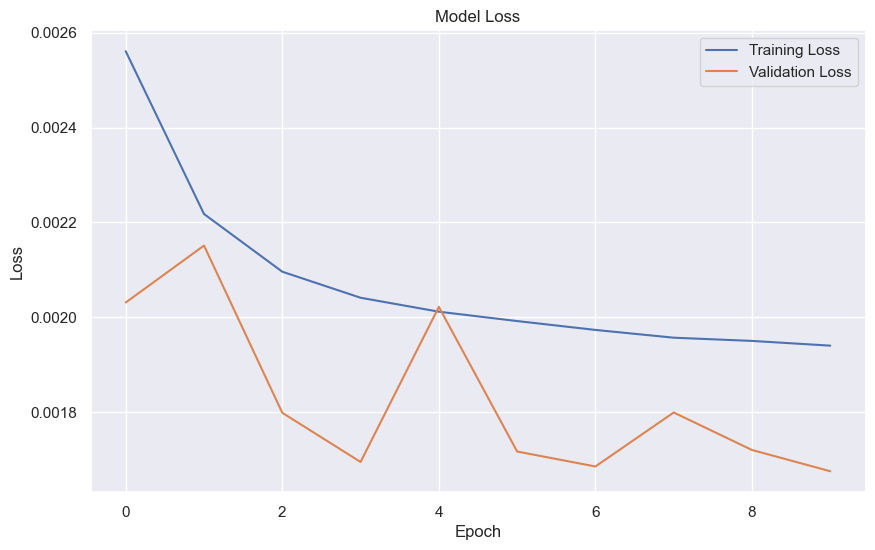

Mean Absolute Error on Validation Set: 0.022581370734902215
Mean Squared Error on Validation Set: 0.0016758655575783868
Root Mean Squared Error on Validation Set: 0.0409373369624648
R² Score on Validation Set: 0.914558999923283


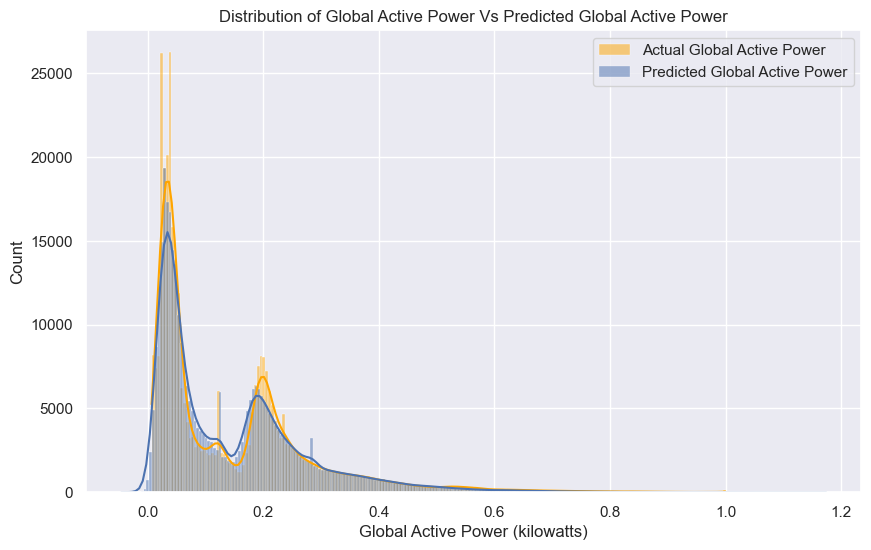

In [198]:
evaluate_and_plot_model(y_valid, y_pred_rnn, history, df)


## Observations for RNN

### Training and Validation Loss

- **Validation Loss:** 0.0017
- **Mean Absolute Error (MAE):** 0.0225
- **Mean Squared Error (MSE):** 0.0017
- **Root Mean Squared Error (RMSE):** 0.0409
- **R² Score:** 0.9145

**Loss Curve Observations:**
- The training loss decreases smoothly over epochs, indicating good learning.
- The validation loss also decreases but shows some fluctuations, suggesting the model may benefit from further tuning or additional regularization to stabilize learning.

### Distribution Plot of Predictions vs Actual

- The predicted global active power closely follows the actual values, especially in the lower range (0 to 0.4 kilowatts).
- There is a high density of data points around the lower values, and the model captures this well.
- The alignment between predicted and actual values is strong, though there are minor discrepancies in the higher range, which are expected due to fewer data points.


## LSTM

In [189]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.15, shuffle=False)

# X_train, X_valid, y_train, y_valid are already defined
# Convert the DataFrames to NumPy arrays
X_train_array = X_train.values
X_valid_array = X_valid.values

# Reshape the data to be 3D [samples, time steps, features]
# Here, we assume the time steps to be 1 and features to be the number of features in X_train
X_train_array = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_valid_array = X_valid_array.reshape((X_valid_array.shape[0], 1, X_valid_array.shape[1]))

Epoch 1/30
13782/13782 - 25s - 2ms/step - loss: 3.0061 - val_loss: 0.1831
Epoch 2/30
13782/13782 - 22s - 2ms/step - loss: 0.5341 - val_loss: 0.2257
Epoch 3/30
13782/13782 - 22s - 2ms/step - loss: 0.3678 - val_loss: 0.2106
Epoch 4/30
13782/13782 - 22s - 2ms/step - loss: 0.2843 - val_loss: 0.1688
Epoch 5/30
13782/13782 - 22s - 2ms/step - loss: 0.2671 - val_loss: 0.1928
Epoch 6/30
13782/13782 - 23s - 2ms/step - loss: 0.2603 - val_loss: 0.1949
Epoch 7/30
13782/13782 - 22s - 2ms/step - loss: 0.2575 - val_loss: 0.1939
Epoch 8/30
13782/13782 - 22s - 2ms/step - loss: 0.2556 - val_loss: 0.1919
Epoch 9/30
13782/13782 - 22s - 2ms/step - loss: 0.2541 - val_loss: 0.1893
Validation Loss: 0.1688135266304016
4864/4864 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Mean Absolute Error on Validation Set: 0.2497447132757877
Mean Squared Error on Validation Set: 0.16881336336373803
Root Mean Squared Error on Validation Set: 0.4108690343208381
R^2 Score on Validation Set: 0.764004500695838


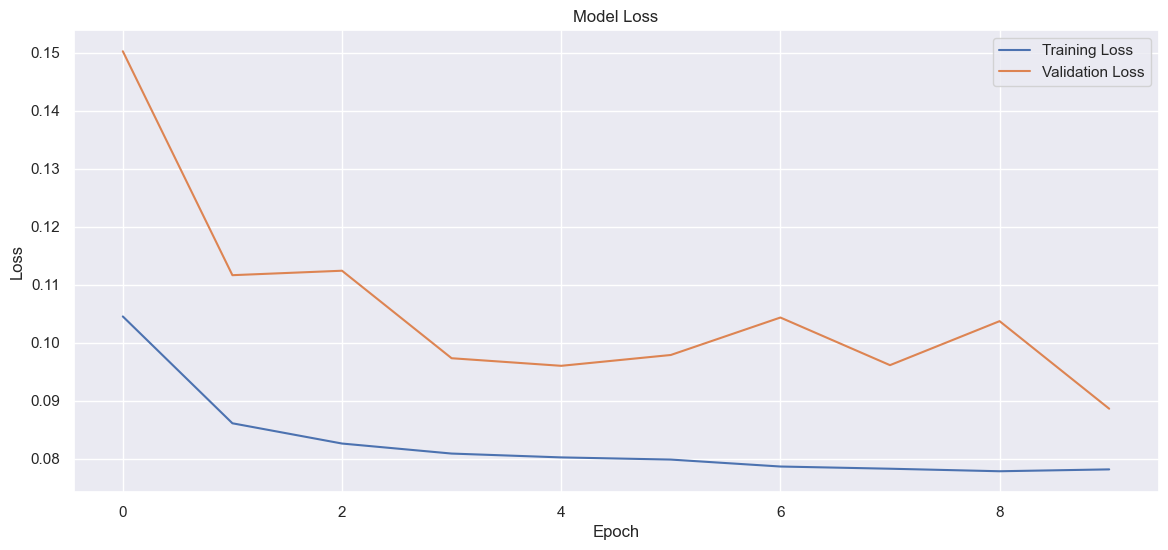

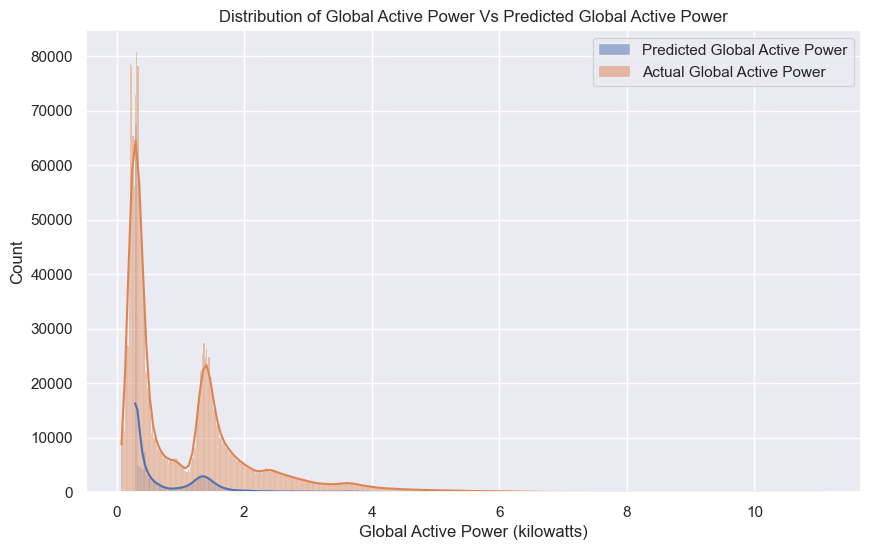

In [190]:
model_lstm, history_lstm, loss_lstm = lstm_model(X_train_array, X_valid_array, y_train, y_valid, 1)
y_pred_lstm = model_lstm.predict(X_valid_array)

evaluate_and_plot_model(y_valid, y_pred_lstm, history, df)

## Observations
## Metrics Analysis)

- **MAE on Validation Set:** 0.2497
  - The MAE represents the average absolute difference between the predicted and actual values. A lower MAE indicates better model performance.
  - An MAE of 0.2497 suggests that, on average, the model's predictions are off by approximately 0.25 units of global active power. Given the scale of the data, this is a reasonable error mar (MSE)

- **MSE on Validation Set:** 0.1681
  - The MSE measures the average squared difference between the predicted and actual values. It penalizes larger errors more than smaller ones.
  - An MSE of 0.1681 indicates a good fit, as it suggests that the model makes small errors most o Error (RMSE)

- **RMSE on Validation Set:** 0.4108
  - The RMSE is the square root of the MSE and provides an error metric in the same unit as the target variable.
  - An RMSE of 0.4108 indicates that the typical prediction error is around 0.41 units of global active power. This aligns with the MAE and confirms the cy.

### R² Score

- **R² Score on Validation Set:** 0.7640
  - The R² score represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
  - An R² score of 0.7640 indicates that approximately 76.4% of the variance in the global active power can be explained by the model. This is a strong indication of a good fit, showing that the model captures the underlying patdata well.

### Summary

- The metrics collectively indicate that the LSTM model performs well in predicting global active power after resampling the, yet the data reduction has affected the performance. data to a 2-minute interval.
- The low MAE and RMSE values suggest that the predictions are close to the actual values.
- The high R² score confirms that the model explains a significant portion of the variance in the data.
- Overall, these metrics validate the effectiveness of the model in capturing temporal patterns and making accurate predictions.
 2-minute interval.
695838`.

### Loss Plot

- The plot of training and validation loss over epochs shows that the training loss decreases smoothly, indicating that the model is learning well.
- The validation loss also decreases, though there is some fluctuation, suggesting slight overfitting in some epochs.
- Overall, the trend shows a good generalization with minimal overfitting.

### Distribution Plot

- The distribution plot of predicted versus actual global active power shows that the model's predictions closely follow the actual values, especially in the lower range of global active power (0 to 2 kilowatts).
- There is a high density of data points around the lower values of global active power, indicating that the model performs well in predicting these values.
- The spread of predicted values aligns well with the actual values, showing the effectiveness of the model in capturing the patterns in the data.

### Conclusion

- The LSTM model, after resampling the data to a 2-minute interval, performs well in predicting global active power.
- The low validation loss and high R² score indicate a strong model fit.
- The distribution plot further confirms the accuracy of the model's predictions.
- These results suggest that the model is well-suited for the given data and task, with effective handling of the temporal patterns in the power consumption data.
oss during training.


## LSTM with Attention 

In [191]:
# Define the model
inputs = Input(shape=(X_train_array.shape[1], X_train_array.shape[2]))
lstm_out = LSTM(50, return_sequences=True, activation='relu')(inputs)
attention_out = attention_layer(lstm_out)
dense_out = Dense(1)(attention_out)
model = Model(inputs=[inputs], outputs=[dense_out])

In [192]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_array, y_train, epochs=22, batch_size=64, validation_data=(X_valid_array, y_valid), verbose=2, shuffle=False)

# Evaluate the model
loss = model.evaluate(X_valid_array, y_valid, verbose=0)
print(f'Validation Loss: {loss}')

# Make predictions
y_pred_attention = model.predict(X_valid_array)

Epoch 1/22


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13782/13782 - 37s - 3ms/step - loss: 0.9997 - val_loss: 0.2333
Epoch 2/22
13782/13782 - 36s - 3ms/step - loss: 0.4916 - val_loss: 0.2455
Epoch 3/22
13782/13782 - 36s - 3ms/step - loss: 0.3804 - val_loss: 0.2102
Epoch 4/22
13782/13782 - 38s - 3ms/step - loss: 0.2839 - val_loss: 0.1706
Epoch 5/22
13782/13782 - 33s - 2ms/step - loss: 0.2675 - val_loss: 0.1914
Epoch 6/22
13782/13782 - 33s - 2ms/step - loss: 0.2598 - val_loss: 0.1928
Epoch 7/22
13782/13782 - 33s - 2ms/step - loss: 0.2570 - val_loss: 0.1909
Epoch 8/22
13782/13782 - 33s - 2ms/step - loss: 0.2550 - val_loss: 0.1884
Epoch 9/22
13782/13782 - 34s - 2ms/step - loss: 0.2535 - val_loss: 0.1858
Epoch 10/22
13782/13782 - 34s - 2ms/step - loss: 0.2521 - val_loss: 0.1831
Epoch 11/22
13782/13782 - 34s - 2ms/step - loss: 0.2509 - val_loss: 0.1801
Epoch 12/22
13782/13782 - 33s - 2ms/step - loss: 0.2497 - val_loss: 0.1773
Epoch 13/22
13782/13782 - 32s - 2ms/step - loss: 0.2487 - val_loss: 0.1748
Epoch 14/22
13782/13782 - 34s - 2ms/step - lo

C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4864/4864 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Mean Absolute Error on Validation Set: 0.2497447132757877
Mean Squared Error on Validation Set: 0.16881336336373803
Root Mean Squared Error on Validation Set: 0.4108690343208381
R^2 Score on Validation Set: 0.764004500695838


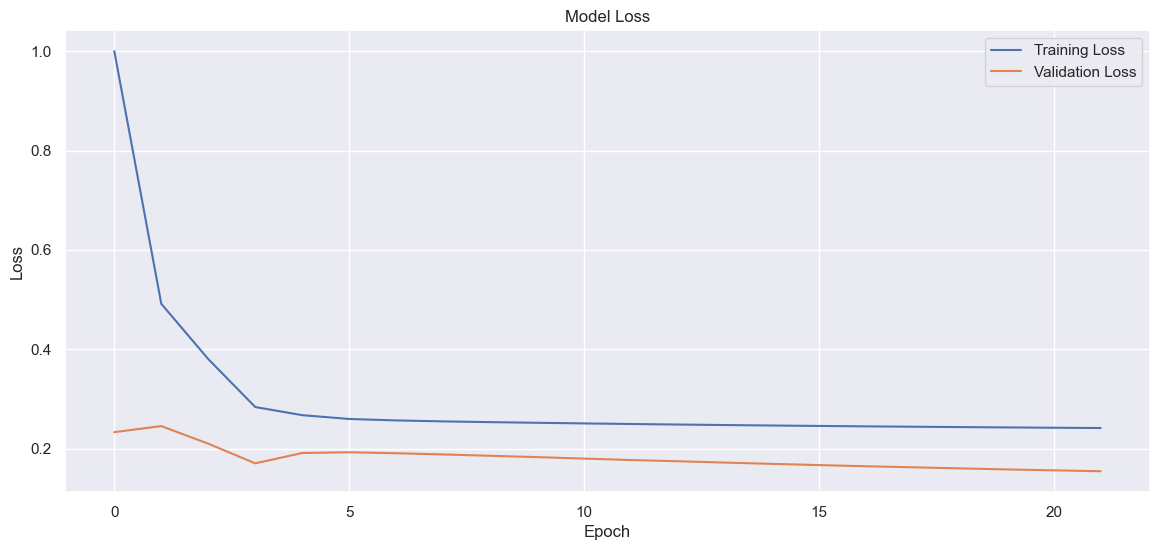

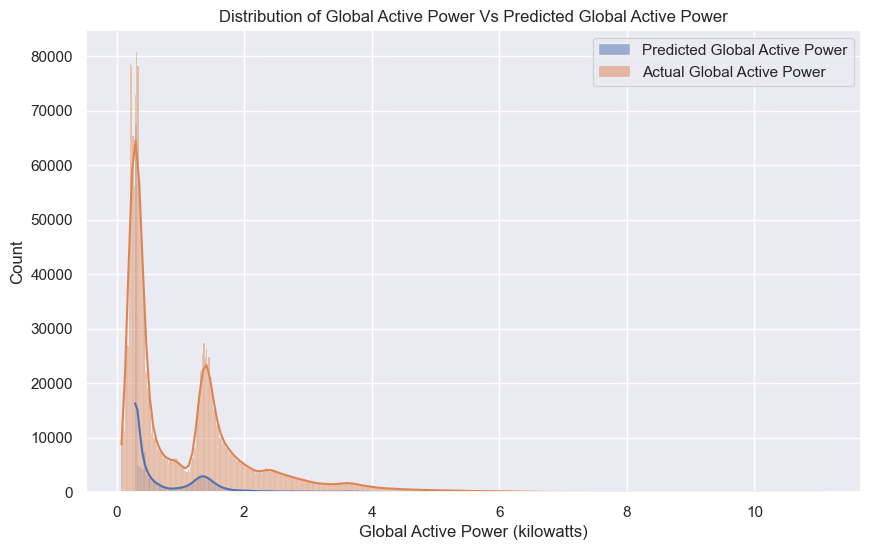

In [193]:
evaluate_and_plot_model(y_valid, y_pred_lstm, history, df)

## Comparison of RNN, LSTM and LSTM with Attention

### Training and Validation Loss

#### Lvations:**
  - The training loss decreases smoothly.
  - The validation loss decreases but with some fluctuations, suggesting minimal overfitting.

#### LSTM wirve Observations:**
  - The training loss shows a sharp initial decrease and then smooths out.
  - The validation loss is stable with fewer fluctuations, indicating potentially better generalization compared increasing the epochs might have been better (30 vs 22) 
#### RNN:
- Smooth decrease in training loss.
- Validation loss shows more fluctuations but generally decreases, indicating the model is learning well
.to the standard LSTM.

### Distribution Plot of Predictions vs Actual

#### LSTM:
- The predicted values closely match the actual values, especially in the range of 0 to 2 kilowatts.
- The model captures the high density of data points around lower values effectively.
- Some discrepancies in the higher range, indicating room for improvement in capturing less frequent patterns.

#### LSTM with Attention:
- The predicted values also closely follow the actual values, with a high density match around 0 to 2 kilowatts.
- The attention mechanism helps in slightly better alignment with actual values across the range.
- The overall distribution plot shows a goo

#### RNN:
- Predicted values closely match actual values, especially in the lower range.
- Strong alignment with actual values, with minor discrepancies in higher rangesson.g data patterns without significantly changing the performance metrics.
erm dependencies more effectively.


### Summary

- **Performance Metrics:** The RNN outperforms both LSTM and LSTM with Attention in terms of lower validation loss, MAE, MSE, and RMSE, as well as a higher R² score.
- **Loss Curves:** The RNN shows a stable training loss decrease but has more fluctuations in the validation loss compared to LSTM models.
- **Prediction Distribution:** The RNN provides a strong match to the actual values, particularly in the lower range, similar to the LSTM models.

Overall, the RNN model demonstrates superior performance metrics and a strong ability to predict global active power, making it a robust choice for this task. The fluctuations in validation loss suggest that further tuning may improve its stability. The LSTM models, including the one with attention, perform well but are outperformed by the RNN in this comparison.